# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

# <div style='padding:7px;background-color:Maroon;color:white;border-radius:2px;font-size:100%;text-align: center'>Regression Modeling<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [1]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np
import os

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})

import scipy.stats as stats
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox

from category_encoders import TargetEncoder

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error,max_error
import xgboost as xg

import pickle
import time



In [2]:
color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=50,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

In [3]:
def kurtosis_color(kurt_val):
    if -1 <= kurt_val <= 1:
        kurt_color = color_good  # Dark Green for near-zero kurtosis (good)
    elif 1 < kurt_val <= 3 or -3 <= kurt_val < -1:
        kurt_color = color_okay  # Yellow for moderate kurtosis
    else:  # kurt_val > 3 or kurt_val < -3
        kurt_color = color_bad  # Maroon for extreme kurtosis
    return kurt_color

def skewness_color(skew_val):
    if -0.5 <= skew_val <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skew_val <= 0.5 or -0.5 < skew_val < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
    return color

In [4]:

# Defining a function to perform Box-Cox
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x + np.spacing(1))
    return transformed_data,lmbda

method_functions =  {
    'log': lambda x: np.log(x + np.spacing(1)),
    'square': np.sqrt,
    'rec': lambda x: np.where(x != 0, 1 / x, np.spacing(1)),
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'cube': lambda x: np.power(x, 3),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method,pkl_path=None):
    transformed_columns = {}
    transformation_params = {}

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name == 'boxcox':
                transformed_values, lmbda = func(df[col])
                transformation_params[new_column] = lmbda 
            else:
                transformed_values = func(df[col])
            transformed_columns[new_column] = transformed_values
    normalized_df = pd.DataFrame(transformed_columns)
    if not os.path.exists(pkl_path):
        os.makedirs(pkl_path)
    file_path = os.path.join(pkl_path,'transformation_params.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(transformation_params, f)
        
    return normalized_df, transformation_params

def process_column(col):
    univar_num(df, col) 
    skew_val = df[col].skew()
    kurt = df[col].kurtosis()
    
    kurt_color = kurtosis_color(kurt)
    color = skewness_color(skew_val)
    
    skewed_col.append(col)
    
    print(f"\n\n{color}Skew for {col} is {skew_val:.4f}{color_neutral}")
    print(f"{color}Kurtosis for {col} is {kurt:.4f}{color_neutral}\n\n")


## <span style="color:Aqua;">Reading model dataset:</span>

In [5]:
df = pd.read_feather('transfered_data.feather')
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
387                   7       1991-11-16           IN               1000   
935                 154       1999-10-05           OH               1000   
991                 257       2006-07-12           OH               1000   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
387        MALE               Associate  machine-op-inspct         camping   
935      FEMALE                      JD    priv-house-serv       cross-fit   
991        MALE                      MD      other-service      basketball   

    insured_relationship incident_date             incident_type  \
387                 wife    2015-02-10  Single Vehicle Collision   
935              husband    2015-01-26   Multi-vehicle Collision   
991       other-relative    2015-02-06  Single Vehicle Collision   

      collision_type incident_severity authorities_contacted incident_state  \
387  Front Collision        Total Loss                 Other             NY   
935   Side Collision        Total Loss                 Other             WV   
991   Rear Collision        Total Loss                 Other             WV   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
387     Hillsdale                       21                           1   
935     Hillsdale                       18                           4   
991     Riverwood                       21                           1   

    property_damage bodily_injuries witnesses police_report_available  \
387             YES               1         2                      NO   
935             YES               2         3                      NO   
991              NO               0         1                      NO   

    auto_make auto_year fraud_reported  age_boxcox  \
387     Honda      2003              N      3.4221   
935    Toyota      2005              Y      4.0394   
991    Accura      2002              N      4.3790   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
387                     1346.4835                130570.6841   
935                     1043.9029                157443.8423   
991                     1284.3895                 96184.4104   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
387              26048                26048           114456.4896  
935              20480                20480           111232.7788  
991                  0                  576            97099.3895

In [7]:
# df = pd.read_feather('clustered.feather')
# df.sample(3)
# 49070
# 1558
# 114
# 30


In [8]:
df['insurance_age'] = pd.to_numeric((df.incident_date.dt.year - df.policy_bind_date.dt.year),errors='raise',downcast='integer')
df['vehicle_age'] = pd.to_numeric((df.incident_date.dt.year - df.auto_year.astype(int)),errors='raise',downcast='integer')

In [9]:
ordinal = ['insured_education_level','incident_severity',]

nominal = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported']

discrete = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year'
            ,'witnesses','bodily_injuries']
continuous = ['age_boxcox','injury_claim_cube','total_claim_amount_boxcox','property_claim_cube','vehicle_claim_boxcox','insurance_age',
              'vehicle_age','policy_deductable','policy_annual_premium_boxcox']

date = ['policy_bind_date','incident_date']

print(len(ordinal + nominal + discrete +continuous + date))
print(len(df.columns))


33
33


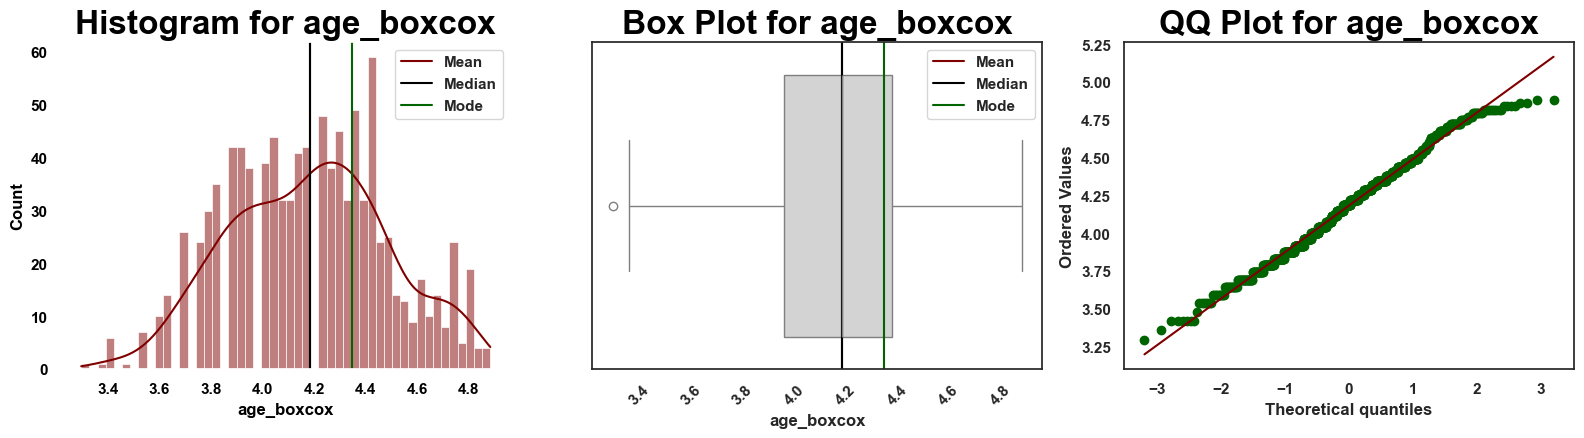



Skew for age_boxcox is -0.0029
Kurtosis for age_boxcox is -0.4858




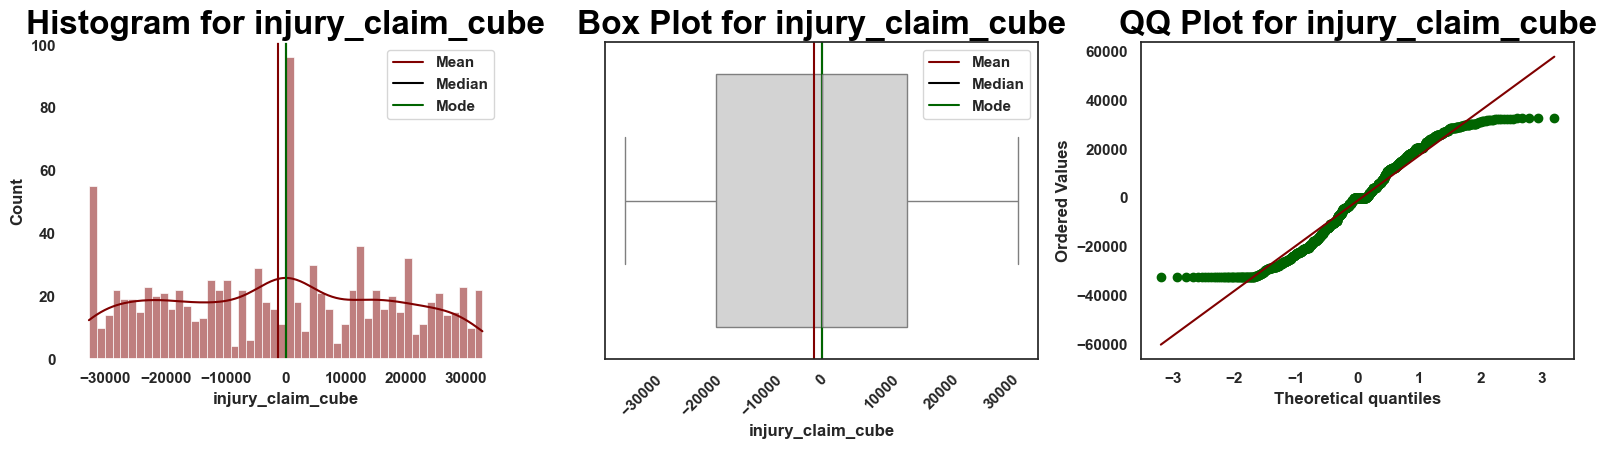



Skew for injury_claim_cube is 0.0054
Kurtosis for injury_claim_cube is -1.0722




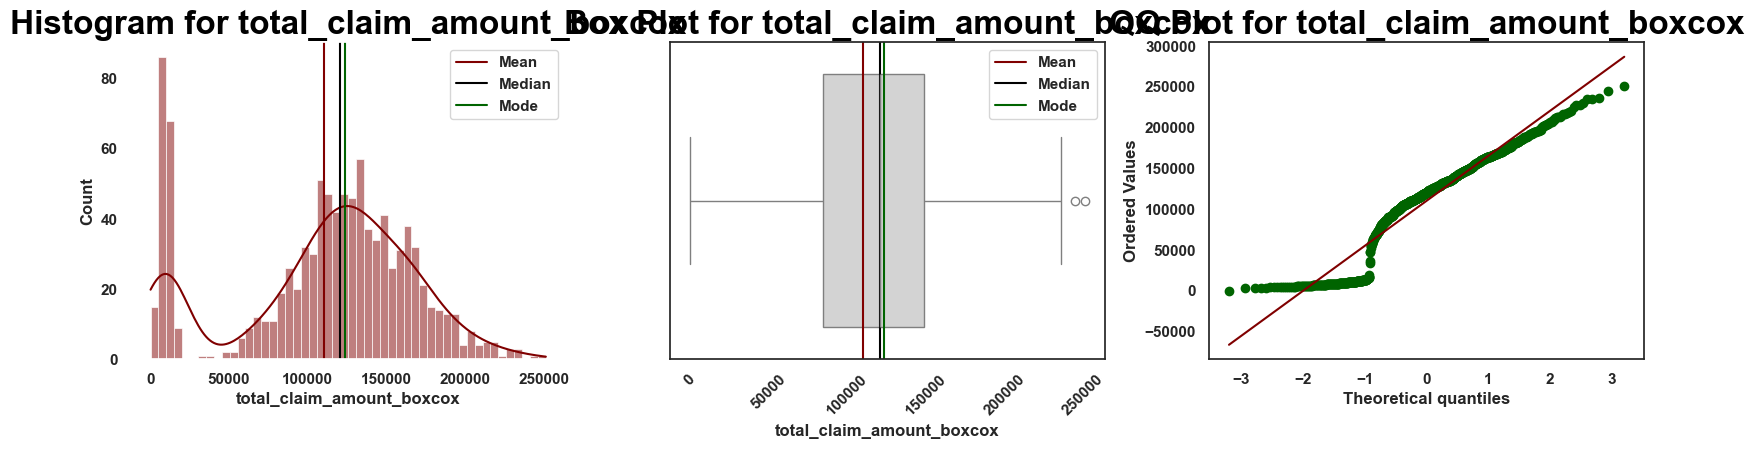



Skew for total_claim_amount_boxcox is -0.5104
Kurtosis for total_claim_amount_boxcox is -0.4878




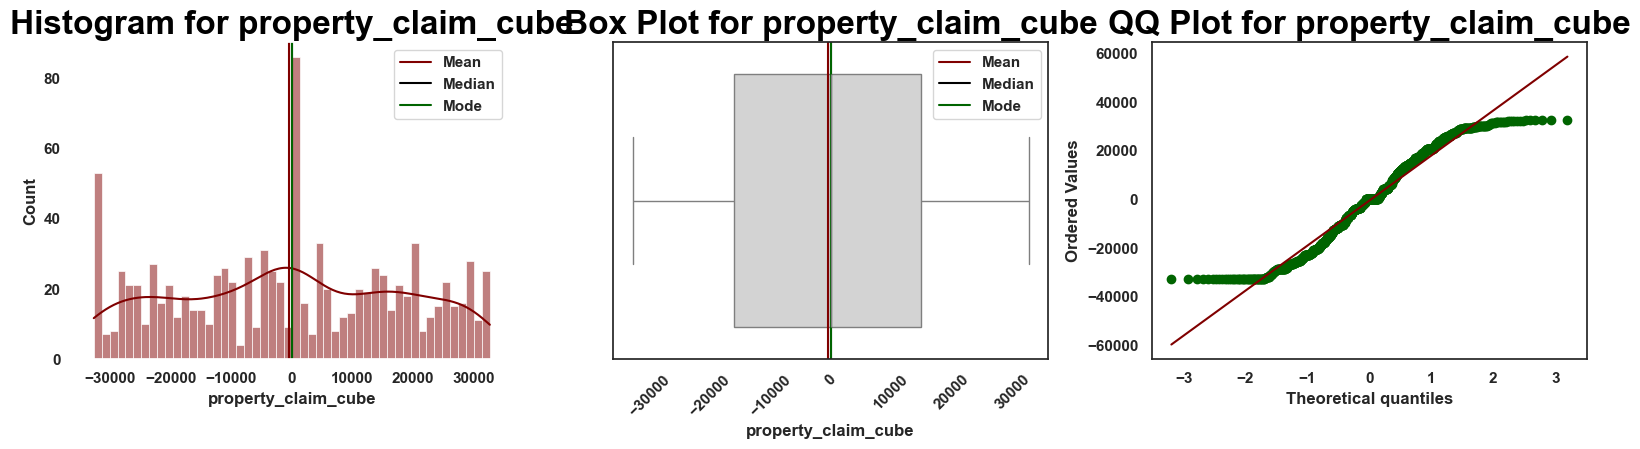



Skew for property_claim_cube is -0.0187
Kurtosis for property_claim_cube is -1.0615




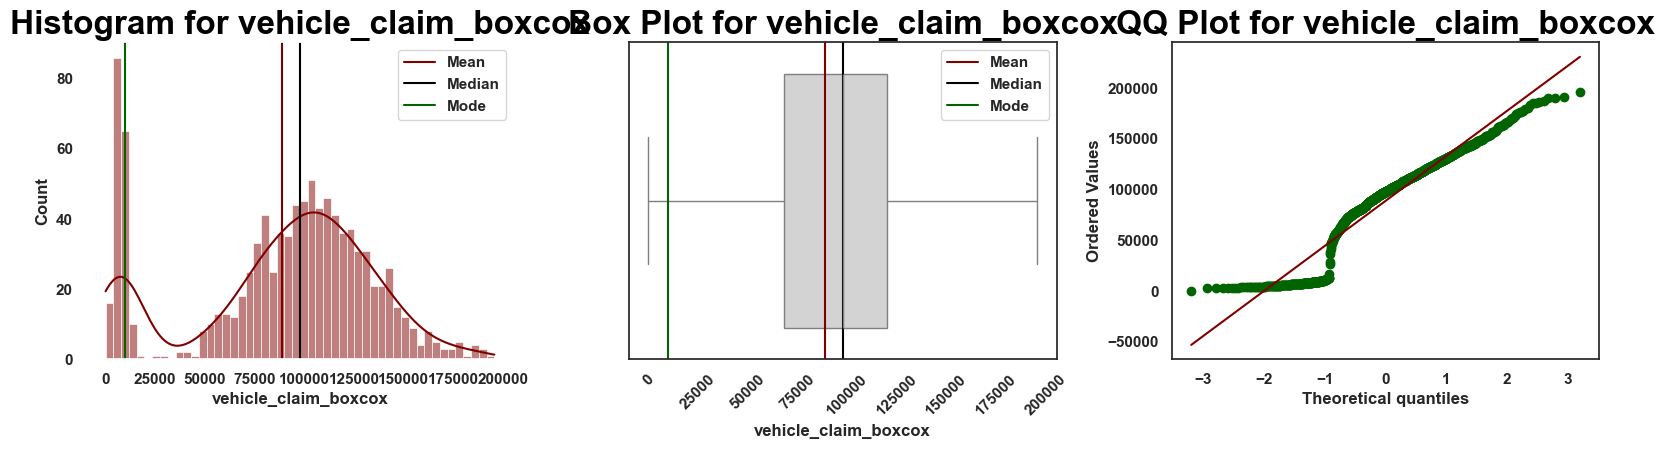



Skew for vehicle_claim_boxcox is -0.5228
Kurtosis for vehicle_claim_boxcox is -0.4890




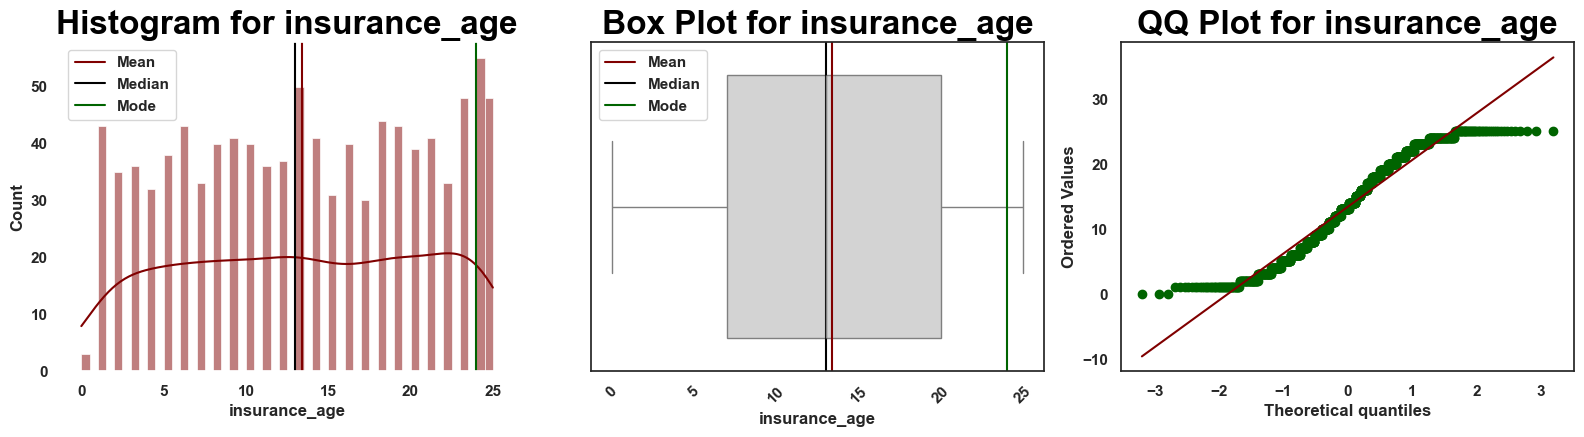



Skew for insurance_age is -0.0525
Kurtosis for insurance_age is -1.2124




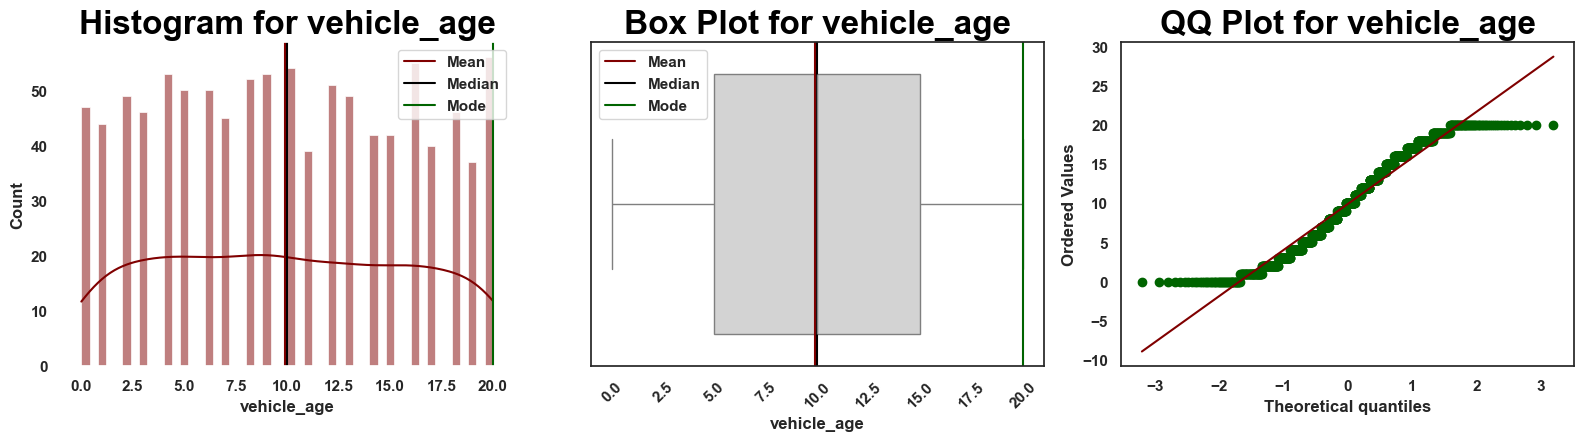



Skew for vehicle_age is 0.0483
Kurtosis for vehicle_age is -1.1719




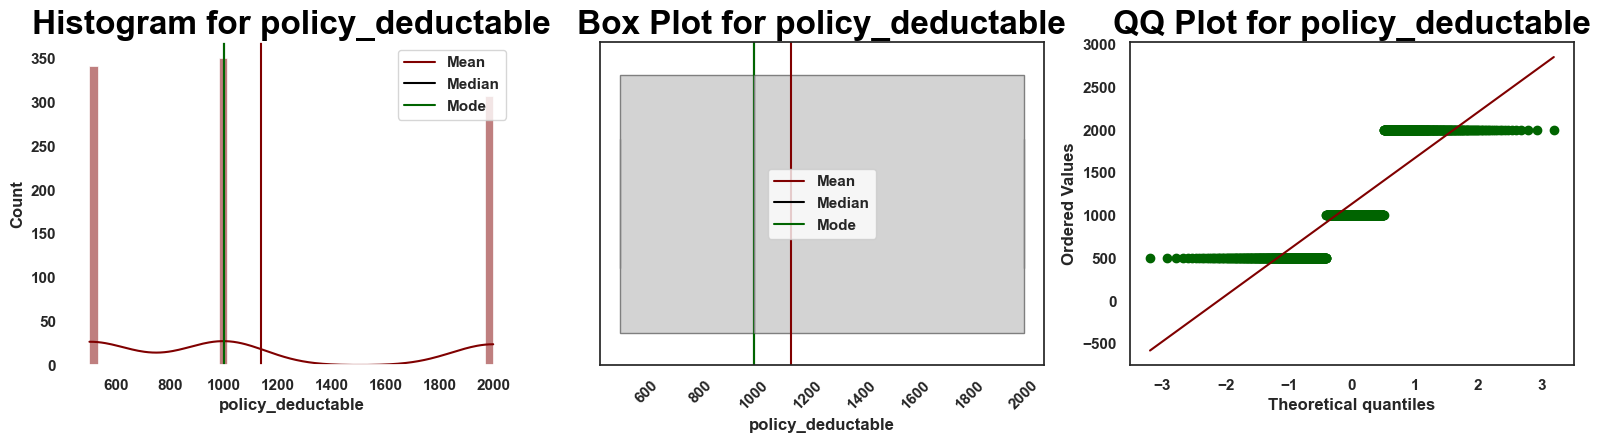



Skew for policy_deductable is 0.4779
Kurtosis for policy_deductable is -1.3769




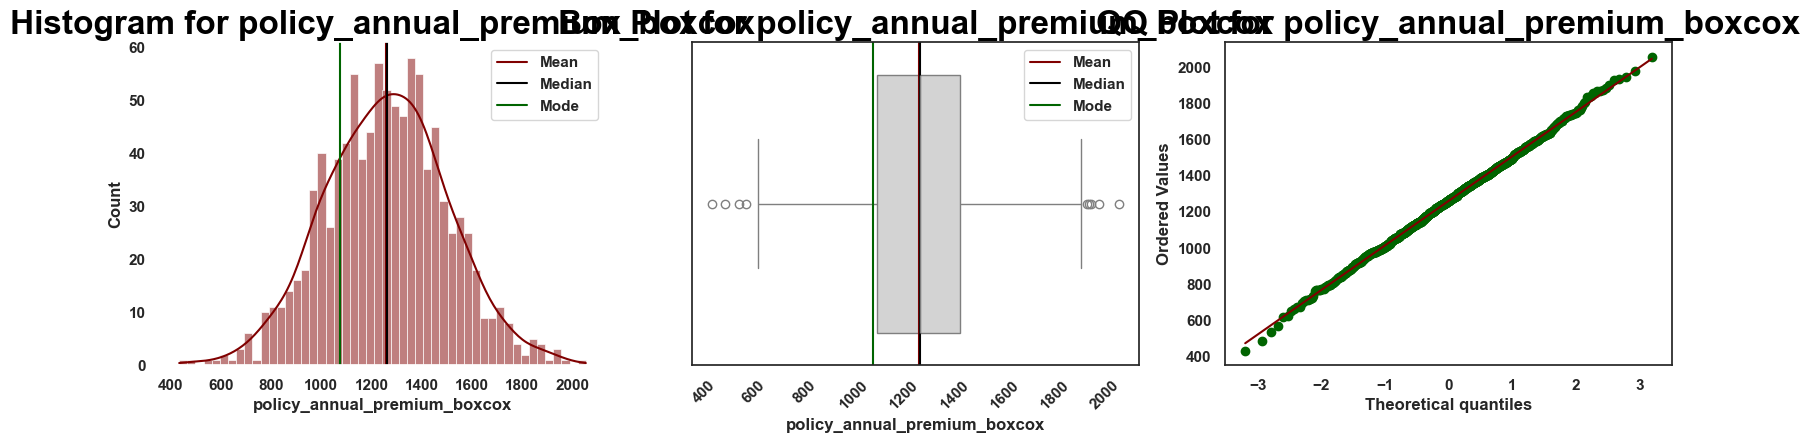



Skew for policy_annual_premium_boxcox is 0.0048
Kurtosis for policy_annual_premium_boxcox is 0.0738




In [10]:
skewed_col = []

_ = list(map(process_column, continuous))

In [11]:
def outlier(df, column,iqr_fact=1.5):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (iqr_fact*iqr)
    lower_threshold = df[column].quantile(0.25) - (iqr_fact*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)
    return df

In [12]:
for i in continuous:
    outlier(df, i,iqr_fact=1.5)
    

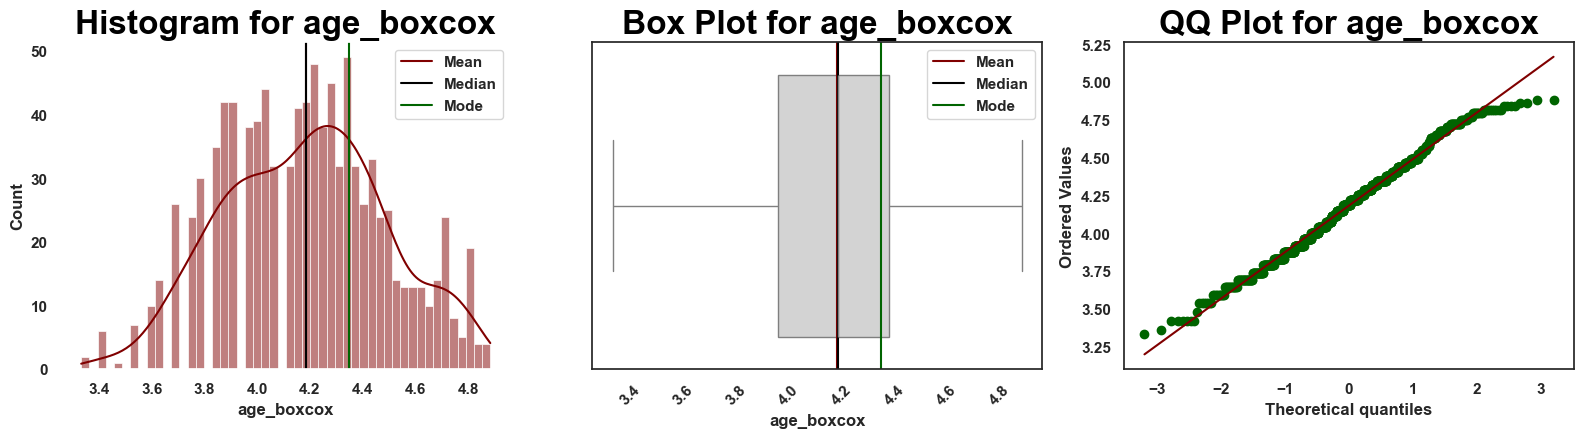



Skew for age_boxcox is -0.0004
Kurtosis for age_boxcox is -0.4931




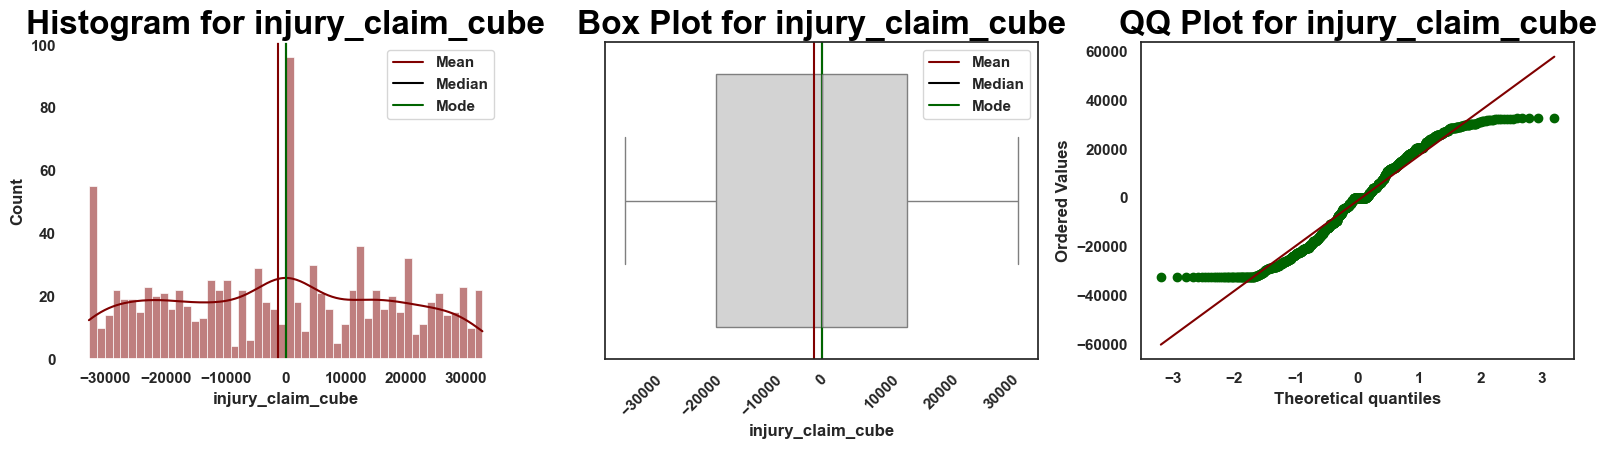



Skew for injury_claim_cube is 0.0054
Kurtosis for injury_claim_cube is -1.0722




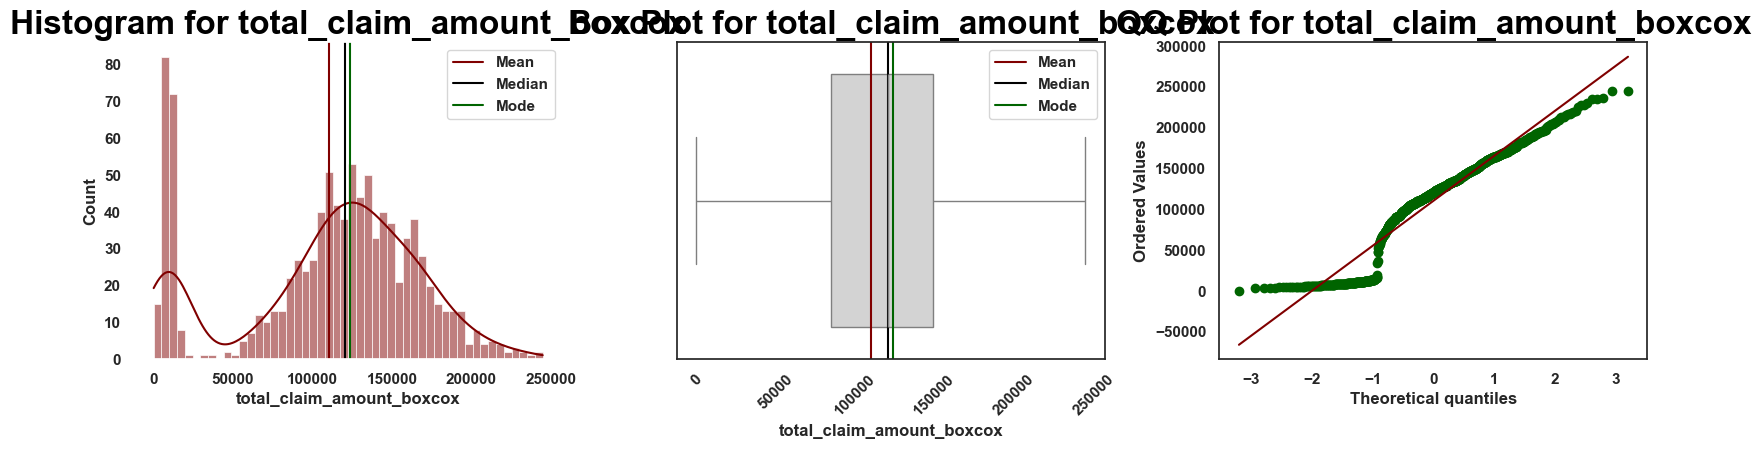



Skew for total_claim_amount_boxcox is -0.5125
Kurtosis for total_claim_amount_boxcox is -0.4916




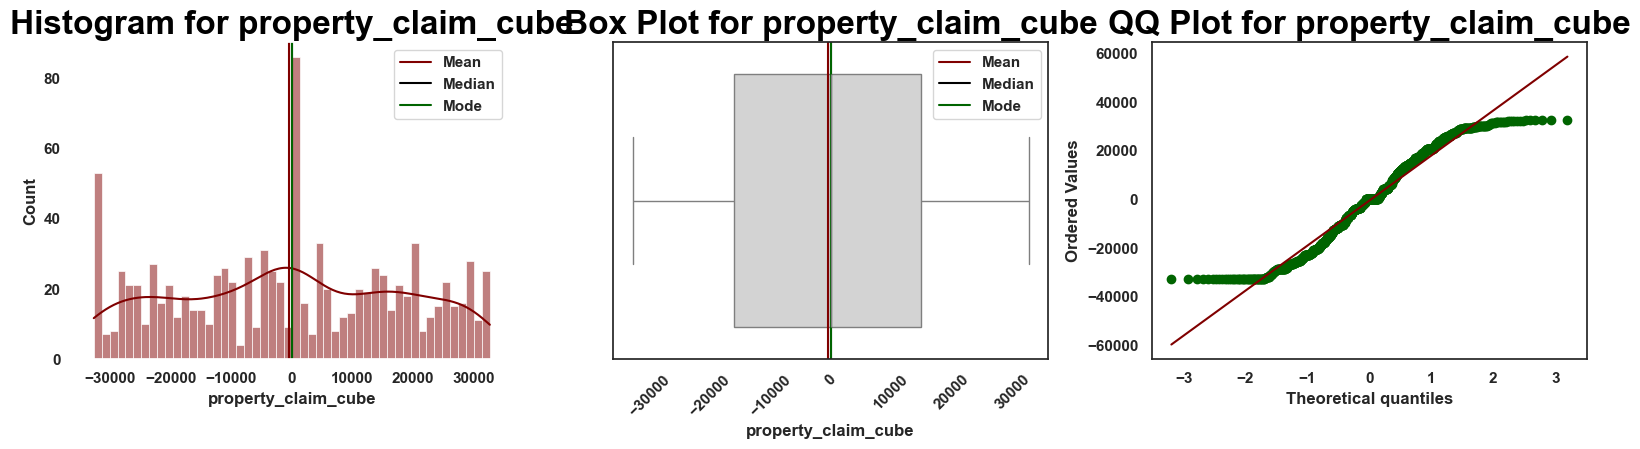



Skew for property_claim_cube is -0.0187
Kurtosis for property_claim_cube is -1.0615




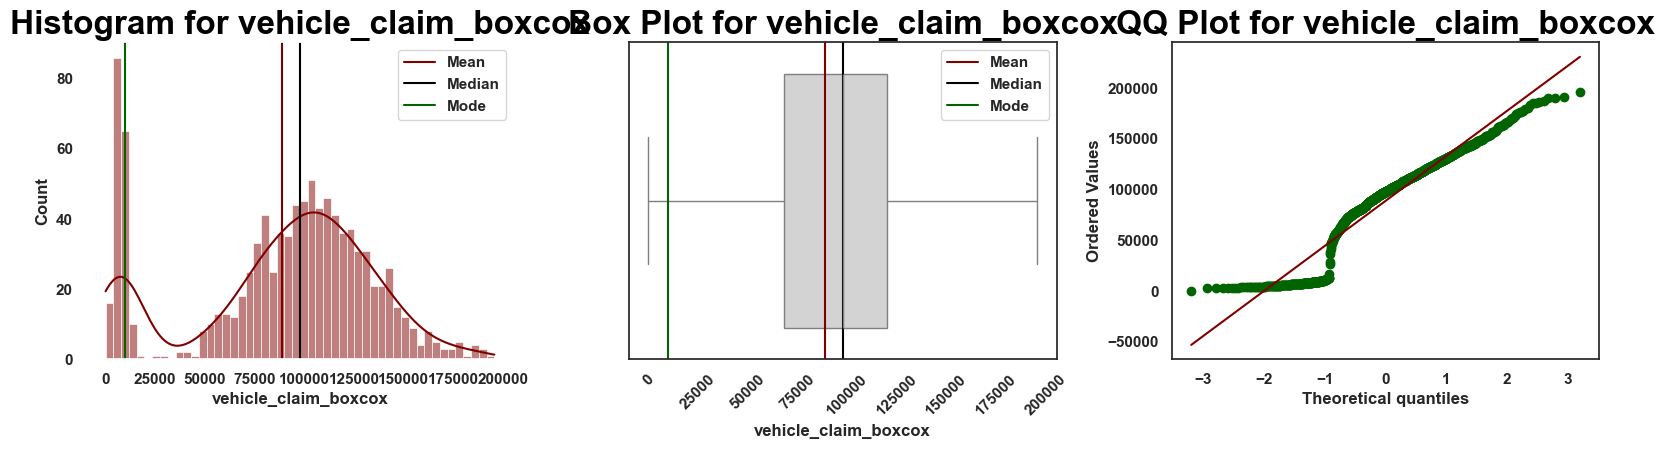



Skew for vehicle_claim_boxcox is -0.5228
Kurtosis for vehicle_claim_boxcox is -0.4890




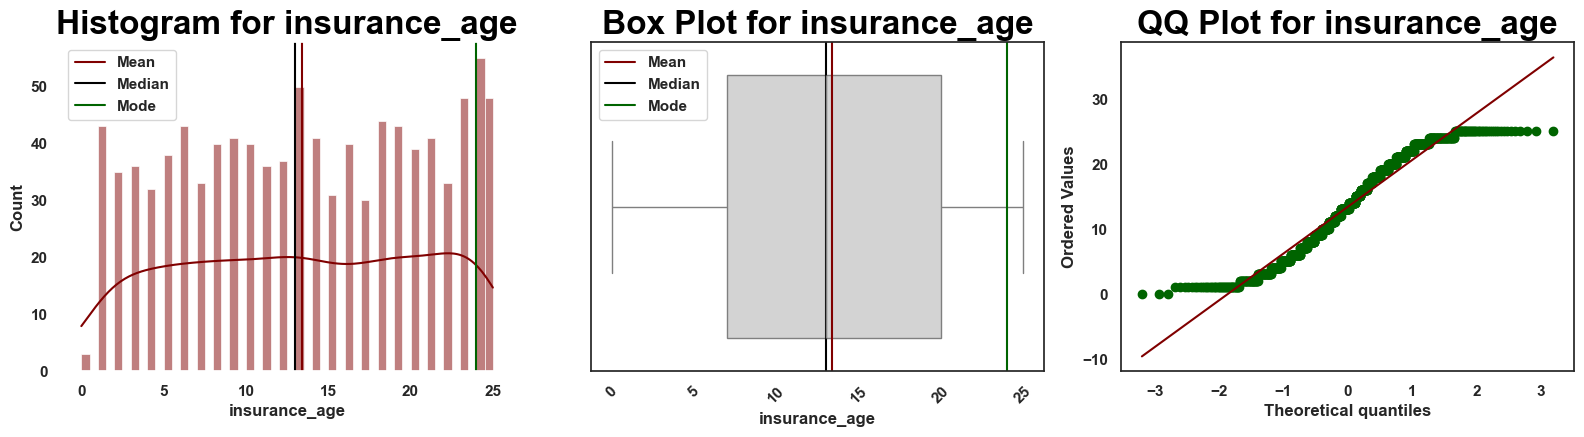



Skew for insurance_age is -0.0525
Kurtosis for insurance_age is -1.2124




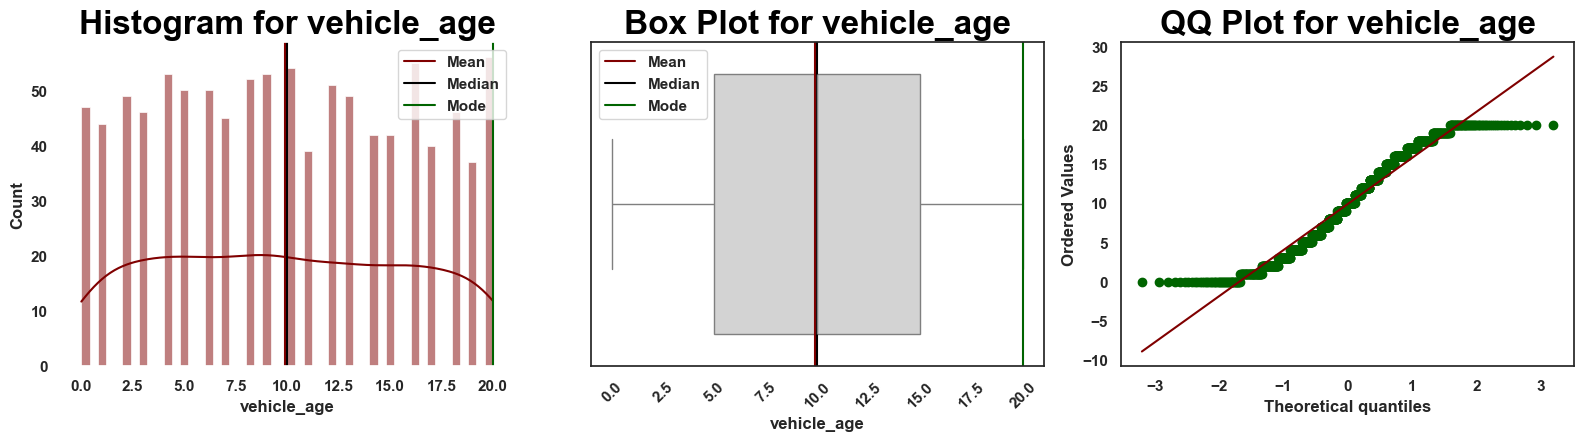



Skew for vehicle_age is 0.0483
Kurtosis for vehicle_age is -1.1719




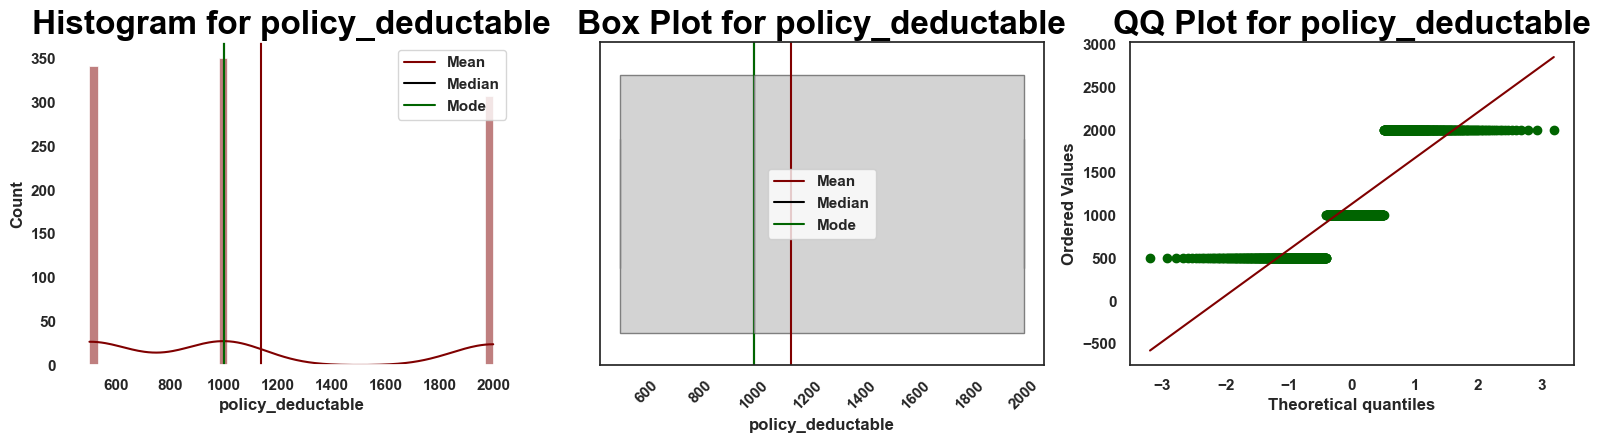



Skew for policy_deductable is 0.4779
Kurtosis for policy_deductable is -1.3769




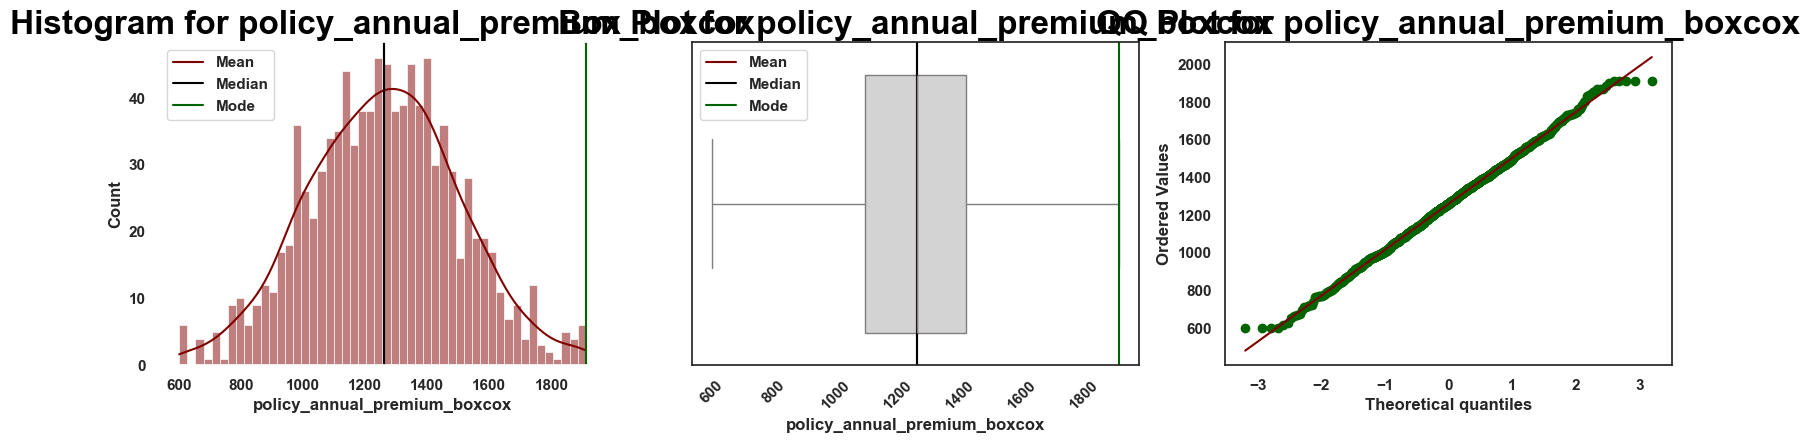



Skew for policy_annual_premium_boxcox is 0.0163
Kurtosis for policy_annual_premium_boxcox is -0.1041




In [13]:
skewed_col = []

_ = list(map(process_column, continuous))

In [14]:
encoder = TargetEncoder()

os.makedirs(f'pkls/Reg_EN/',exist_ok=True)

In [15]:
for i in nominal:
    df[i] = encoder.fit_transform(df[i],df['policy_annual_premium_boxcox'])
    df[i] = pd.to_numeric(df[i],errors='raise',downcast='integer')
    print(i,'\n',df[i].min(), '--', df[i].max())
    with open(f'pkls/Reg_EN/encoder_{i}.pkl', 'wb') as f:
        pickle.dump(encoder, f)

policy_state 
 1256.4721074653764 -- 1264.0550613282498
insured_sex 
 1250.8981527163003 -- 1270.4027313444292
insured_occupation 
 1219.0101069211182 -- 1310.1585893998197
insured_hobbies 
 1180.2909816718095 -- 1308.7609934709553
insured_relationship 
 1251.4785950816279 -- 1274.4198723409093
incident_type 
 1237.0583583464488 -- 1277.4809297514462
collision_type 
 1250.1644005612245 -- 1273.9123695088988
authorities_contacted 
 1244.0246613781917 -- 1276.5757638330176
incident_state 
 1233.3986920851662 -- 1296.919923345424
incident_city 
 1238.8211382510315 -- 1307.6092255167312
property_damage 
 1259.821953543553 -- 1259.98503610473
police_report_available 
 1257.6687132044638 -- 1263.8947722035277
auto_make 
 1200.8641118206 -- 1323.3975870631389
fraud_reported 
 1253.885122422616 -- 1261.9112183040434


In [16]:
df.sample(3)

months_as_customer policy_bind_date  policy_state  policy_deductable  \
701                 162       1991-01-05     1264.0551                500   
355                 256       2014-12-13     1264.0551                500   
184                 296       1993-02-23     1264.0551               1000   

     insured_sex insured_education_level  insured_occupation  insured_hobbies  \
701    1250.8982               Associate           1219.0101        1274.0494   
355    1250.8982                      MD           1262.8020        1223.1441   
184    1270.4027                 Masters           1269.4790        1279.7991   

     insured_relationship incident_date  incident_type  collision_type  \
701             1252.5800    2015-02-09      1246.2443       1259.7932   
355             1251.4786    2015-02-06      1277.4809       1259.7932   
184             1255.4897    2015-01-06      1277.4809       1250.1644   

    incident_severity  authorities_contacted  incident_state  incident_city  \
701      Major Damage              1276.5758       1257.3898      1266.2217   
355        Total Loss              1276.5758       1278.0321      1266.2217   
184      Major Damage              1268.2596       1257.3898      1256.2772   

    incident_hour_of_the_day number_of_vehicles_involved  property_damage  \
701                       17                           4        1259.8220   
355                       11                           1        1259.8220   
184                       18                           1        1259.9850   

    bodily_injuries witnesses  police_report_available  auto_make auto_year  \
701               2         1                1257.6687  1200.8641      1996   
355               0         0                1257.6687  1220.3377      1997   
184               0         2                1257.6687  1200.8641      2013   

     fraud_reported  age_boxcox  policy_annual_premium_boxcox  \
701       1253.8851      4.0005                      967.1607   
355       1261.9112      4.3484                     1206.3628   
184       1261.9112      4.4382                     1144.2929   

     total_claim_amount_boxcox  injury_claim_cube  property_claim_cube  \
701                 70775.1947                232                  232   
355                132343.8301             -12096                -9704   
184                113688.2616             -10424               -10424   

     vehicle_claim_boxcox  insurance_age  vehicle_age  
701            63461.4626             24           19  
355           107863.5775              1           18  
184           102571.7031             22            2

In [17]:
for i in ordinal+discrete:
    grouping = df.groupby(i,observed=False)['policy_annual_premium_boxcox'].mean().rank(method='first').reset_index().sort_values('policy_annual_premium_boxcox')
    en_list = dict(zip(grouping[i], grouping['policy_annual_premium_boxcox'].astype(int)))
    df[i] = pd.to_numeric(df[i].map(en_list),errors='raise',downcast='integer')
    print(f'{i} -- {en_list}')
    

insured_education_level -- {'Masters': 1, 'JD': 2, 'College': 3, 'Associate': 4, 'PhD': 5, 'MD': 6, 'High School': 7}
incident_severity -- {'Trivial Damage': 1, 'Major Damage': 2, 'Minor Damage': 3, 'Total Loss': 4}
months_as_customer -- {410: 1, 419: 2, 303: 3, 59: 4, 389: 5, 17: 6, 213: 7, 77: 8, 98: 9, 35: 10, 237: 11, 324: 12, 425: 13, 157: 14, 167: 15, 90: 16, 153: 17, 415: 18, 72: 19, 315: 20, 10: 21, 385: 22, 227: 23, 236: 24, 467: 25, 62: 26, 472: 27, 202: 28, 291: 29, 399: 30, 465: 31, 109: 32, 468: 33, 317: 34, 308: 35, 270: 36, 66: 37, 463: 38, 5: 39, 81: 40, 131: 41, 356: 42, 149: 43, 412: 44, 162: 45, 288: 46, 1: 47, 94: 48, 87: 49, 478: 50, 404: 51, 152: 52, 241: 53, 83: 54, 38: 55, 284: 56, 231: 57, 6: 58, 136: 59, 258: 60, 61: 61, 32: 62, 386: 63, 193: 64, 456: 65, 243: 66, 405: 67, 332: 68, 101: 69, 113: 70, 426: 71, 287: 72, 435: 73, 104: 74, 121: 75, 132: 76, 440: 77, 392: 78, 334: 79, 230: 80, 189: 81, 108: 82, 36: 83, 406: 84, 119: 85, 107: 86, 438: 87, 112: 88, 39

In [ ]:
df.sample(3)

months_as_customer policy_bind_date  policy_state  policy_deductable  \
814                 101       1996-01-20     1256.4721               2000   
284                  81       2007-04-28     1264.0551               2000   
377                  62       2014-11-14     1264.0551               2000   

     insured_sex  insured_education_level  insured_occupation  \
814    1250.8982                        1           1263.5768   
284    1250.8982                        6           1259.7170   
377    1270.4027                        2           1310.1586   

     insured_hobbies  insured_relationship incident_date  incident_type  \
814        1282.8927             1274.4199    2015-01-16      1246.2443   
284        1305.5216             1274.4199    2015-02-13      1246.2443   
377        1294.0602             1255.4897    2015-02-28      1277.4809   

     collision_type  incident_severity  authorities_contacted  incident_state  \
814       1250.1644                  4              1268.2596       1296.9199   
284       1273.9124                  2              1244.0247       1278.0321   
377       1273.9124                  4              1276.5758       1296.9199   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
814      1307.6092                        12                            3   
284      1307.6092                        19                            3   
377      1261.8865                         8                            4   

     property_damage  bodily_injuries  witnesses  police_report_available  \
814        1259.8220                1          4                1263.8948   
284        1259.9850                3          3                1263.8948   
377        1259.9850                3          2                1257.6687   

     auto_make  auto_year  fraud_reported  age_boxcox  \
814  1220.3377          4       1261.9112      3.6429   
284  1253.6027         16       1261.9112      4.1141   
377  1264.1469         16       1261.9112      3.6929   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
814                     1146.0098                154128.7304   
284                     1392.5329                169289.2295   
377                     1263.7455                 92936.3638   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
814              10560                10560           102114.7642   
284             -25920               -25920           125924.9027   
377              -4416               -25128            72328.4811   

     insurance_age  vehicle_age  
814             19            5  
284              8            6  
377              1            6

## <span style="color:Aqua;">Preparing the data afor modeling:</span>

In [19]:
continuous = ['age_boxcox','policy_annual_premium_boxcox',
    'insurance_age','vehicle_age','auto_year', 'vehicle_claim_boxcox']

In [20]:
df.drop_duplicates()
x = df.drop(['total_claim_amount_boxcox','policy_deductable','policy_bind_date','incident_date','injury_claim_cube','property_claim_cube'],axis=1)
y = df['total_claim_amount_boxcox']

In [21]:
x.describe()

months_as_customer  policy_state  insured_sex  insured_education_level  \
count           1000.0000     1000.0000    1000.0000                1000.0000   
mean             197.2010     1259.9288    1259.9288                   4.0200   
std              102.8837        3.2098       9.7304                   2.0489   
min                1.0000     1256.4721    1250.8982                   1.0000   
25%              114.7500     1256.4721    1250.8982                   2.0000   
50%              197.0000     1259.0123    1250.8982                   4.0000   
75%              284.0000     1264.0551    1270.4027                   6.0000   
max              391.0000     1264.0551    1270.4027                   7.0000   

       insured_occupation  insured_hobbies  insured_relationship  \
count           1000.0000        1000.0000             1000.0000   
mean            1259.8253        1259.3702             1259.9288   
std               26.0693          33.7462                7.9192   
min             1219.0101        1180.2910             1251.4786   
25%             1237.1163        1232.2101             1252.5800   
50%             1262.8020        1272.4424             1261.6209   
75%             1277.1343        1279.7991             1261.9903   
max             1310.1586        1308.7610             1274.4199   

       incident_type  collision_type  incident_severity  \
count      1000.0000       1000.0000          1000.0000   
mean       1259.9316       1259.9288             2.8240   
std          15.8252          9.4002             0.9412   
min        1237.0584       1250.1644             1.0000   
25%        1246.2443       1250.1644             2.0000   
50%        1246.2443       1259.7932             3.0000   
75%        1277.4809       1273.9124             4.0000   
max        1277.4809       1273.9124             4.0000   

       authorities_contacted  incident_state  incident_city  \
count              1000.0000       1000.0000      1000.0000   
mean               1259.9288       1260.5324      1259.9287   
std                  12.5597         18.3383        20.9746   
min                1244.0247       1233.3987      1238.8211   
25%                1244.0247       1244.4832      1240.9716   
50%                1258.5390       1257.3898      1256.2772   
75%                1268.2596       1278.0321      1266.2217   
max                1276.5758       1296.9199      1307.6092   

       incident_hour_of_the_day  number_of_vehicles_involved  property_damage  \
count                 1000.0000                    1000.0000        1000.0000   
mean                    12.4150                       3.4900        1259.9288   
std                      6.9670                       0.7017           0.0776   
min                      1.0000                       1.0000        1259.8220   
25%                      7.0000                       3.0000        1259.8220   
50%                     12.0000                       4.0000        1259.9850   
75%                     19.0000                       4.0000        1259.9850   
max                     24.0000                       4.0000        1259.9850   

       bodily_injuries  witnesses  police_report_available  auto_make  \
count        1000.0000  1000.0000                1000.0000  1000.0000   
mean            1.9880     2.5100                1259.9288  1259.9677   
std             0.8176     1.1248                   2.9954    32.6193   
min             1.0000     1.0000                1257.6687  1200.8641   
25%             1.0000     2.0000                1257.6687  1232.6410   
50%             2.0000     3.0000                1257.6687  1256.4648   
75%             3.0000     4.0000                1263.8948  1274.4258   
max             3.0000     4.0000                1263.8948  1323.3976   

       auto_year  fraud_reported  age_boxcox  policy_annual_premium_boxcox  \
count  1000.0000       1000.0000   1000.0000                     1000.0000   
mean     10.8990    

In [22]:
y.describe()

count     1000.0000
mean    110315.3273
std      57133.5064
min        129.5888
25%      84877.8054
50%     120714.3523
75%     148899.2008
max     244931.2938
Name: total_claim_amount_boxcox, dtype: float64

In [23]:
y.value_counts()

total_claim_amount_boxcox
123718.2093    5
4377.4001      4
90089.7132     4
5363.3234      4
159808.2039    4
              ..
8315.6507      1
170476.9504    1
13598.0773     1
125954.8023    1
107499.5502    1
Name: count, Length: 762, dtype: int64

## <span style="color:Aqua;">Splitting data for train_test and resampling imbalanced data classess:</span>

In [24]:
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size=.3,random_state=42)

In [25]:
print(x_train.shape,'----', y_train.shape)
print(x_test.shape,'----', y_test.shape)

(700, 27) ---- (700,)
(300, 27) ---- (300,)


In [26]:
df.police_report_available.value_counts().index

Index([1257.6687132044638, 1263.8947722035277], dtype='float64', name='police_report_available')

In [27]:
x_test.sample(2)

months_as_customer  policy_state  insured_sex  insured_education_level  \
643                 366     1256.4721    1250.8982                        1   
277                 243     1264.0551    1270.4027                        5   

     insured_occupation  insured_hobbies  insured_relationship  incident_type  \
643           1262.8020        1180.2910             1255.4897      1277.4809   
277           1262.8020        1257.5219             1251.4786      1277.4809   

     collision_type  incident_severity  authorities_contacted  incident_state  \
643       1273.9124                  2              1244.0247       1242.8817   
277       1259.7932                  3              1258.5390       1246.1703   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
643      1266.2217                        19                            4   
277      1261.8865                        10                            4   

     property_damage  bodily_injuries  witnesses  police_report_available  \
643        1259.8220                1          4                1257.6687   
277        1259.8220                3          1                1257.6687   

     auto_make  auto_year  fraud_reported  age_boxcox  \
643  1274.4258          5       1253.8851      4.1851   
277  1247.2596         18       1253.8851      4.2853   

     policy_annual_premium_boxcox  vehicle_claim_boxcox  insurance_age  \
643                     1548.2797            87031.4178              1   
277                     1415.3470           102571.7031             13   

     vehicle_age  
643           14  
277           11

In [28]:
y_test.sample(2)

687   206866.3332
298    10452.5769
Name: total_claim_amount_boxcox, dtype: float64

## <span style="color:Aqua;">Normalizing / Scaling the data:</span>

In [29]:
# print("x_train shape:", x_train[continuous + nominal].shape)
# print("Continuous columns:", continuous)
# print("Nominal columns:", nominal)
# print("Available columns in x_train:", x_train.columns.tolist())

In [30]:
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train[continuous + nominal])
# x_test_scaled = scaler.transform(x_test[continuous + nominal])
# y_train, y_test = y_train.values.ravel(), y_test.values.ravel()

# os.makedirs(r'pkls', exist_ok=True)
# with open(r'pkls/scale_reg.pkl','wb') as f:
#     pickle.dump(scaler,f)

# print(x_train[continuous + nominal])

In [31]:
# x_train_scaled_continuous = pd.DataFrame(x_train_scaled, columns=continuous + nominal)
# x_test_scaled_continuous = pd.DataFrame(x_test_scaled, columns=continuous + nominal)

In [32]:
# x_train_drop = x_train.drop(columns = continuous + nominal,axis=1)
# x_test_drop  = x_test.drop(columns = continuous + nominal, axis=1)

In [33]:
# x_train_scaled_df = pd.concat([x_train_drop.reset_index(drop=True), x_train_scaled_continuous.reset_index(drop=True)], axis=1)
# x_test_scaled_df = pd.concat([x_test_drop.reset_index(drop=True),x_test_scaled_continuous.reset_index(drop=True)], axis=1)

In [34]:
# print(x_train.shape)
# x_train.sample(1)

In [35]:
# print(x_train_scaled_df.shape)
# x_train_scaled_df.sample(1)

In [36]:
# print(x_test.shape)
# x_test.sample(1)

In [37]:
# print(x_test_scaled_df.shape)
# x_test_scaled_df.sample(1)

## <span style="color:Aqua;">Training all the model:</span>

#### <span style="color:Khaki;">Defing the function to train and evaluate the model:</span>

In [38]:
def evaluate_model(model, x_train, y_train, x_test, y_test, color_positive='\033[92m', reset_color='\033[0m'):
    print(f"\n{model.__class__.__name__}\n")

    start_time = time.time()
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    y_preds_train = model.predict(x_train)
    training_time = time.time() - start_time

    print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

    if isinstance(model, LinearRegression) or (isinstance(model, MultiOutputRegressor) and isinstance(model.estimator, LinearRegression)):
        if isinstance(model, MultiOutputRegressor):
            coefs = [est.coef_ for est in model.estimators_]
        else:
            coefs = model.coef_
        print(f"{color_positive}Coefficients - {reset_color} {coefs}")

    metrics = {
        "Mean Squared Error": mean_squared_error,
        "R2 Score": r2_score,
        "Mean Absolute Error": mean_absolute_error,
        "Median Absolute Error": median_absolute_error,
        "Explained Variance Score": explained_variance_score,
        "Max Error": max_error
    }

    def safe_metric(metric_func, y_true, y_pred):
        if isinstance(y_true, (pd.DataFrame, pd.Series)):
            y_true = y_true.values
        if isinstance(y_pred, (pd.DataFrame, pd.Series)):
            y_pred = y_pred.values
        
        try:
            return metric_func(y_true, y_pred, multioutput='uniform_average')
        except TypeError:
            if y_true.ndim > 1 and y_true.shape[1] > 1:
                return np.mean([metric_func(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])
            else:
                return metric_func(y_true, y_pred)

    for metric_name, metric_func in metrics.items():
        test_score = safe_metric(metric_func, y_test, y_preds)
        train_score = safe_metric(metric_func, y_train, y_preds_train)
        
        print(f"{color_positive}Test {metric_name} {reset_color} -- {test_score:.4f}")
        print(f"{color_positive}Train {metric_name} {reset_color} -- {train_score:.4f}\n")

    # Handle Root Mean Squared Error separately
    test_rmse = np.sqrt(safe_metric(mean_squared_error, y_test, y_preds))
    train_rmse = np.sqrt(safe_metric(mean_squared_error, y_train, y_preds_train))
    print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {test_rmse:.4f}")
    print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {train_rmse:.4f}\n")

    print('-'*50)

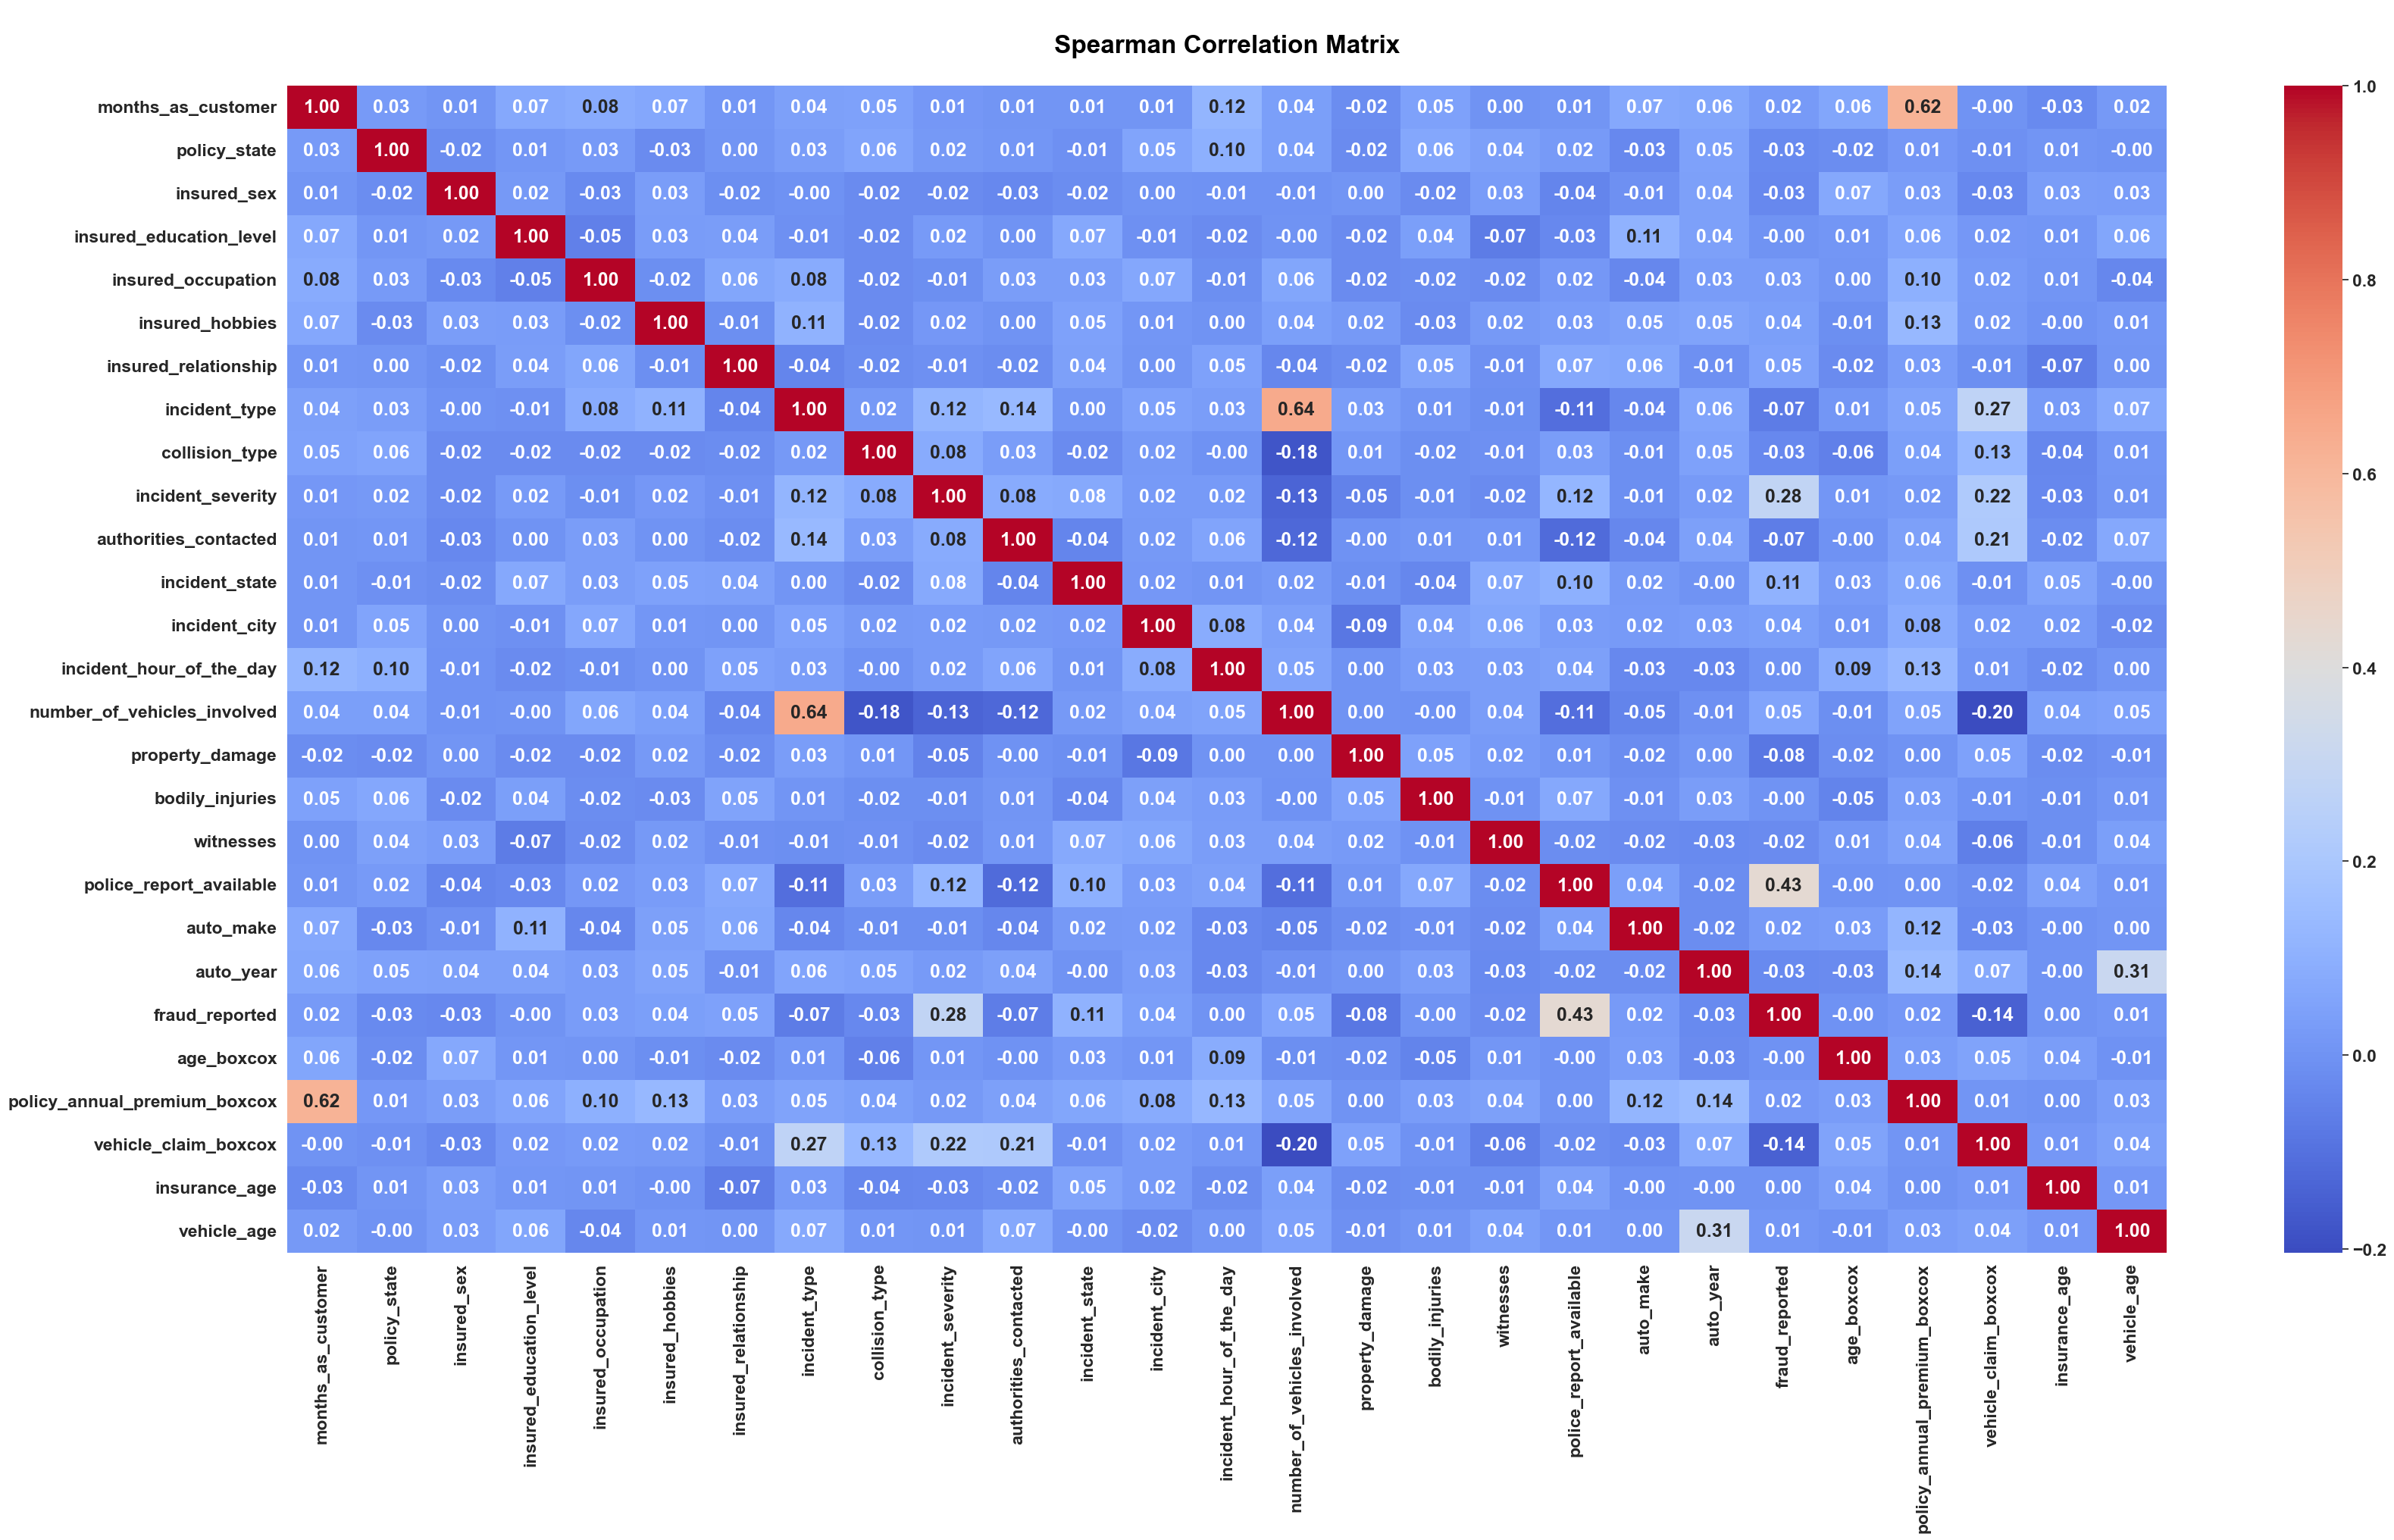

In [39]:
plt.figure(figsize=(40,20))
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
# continuous.extend(['policy_annual_premium_boxcox','insured_sex','property_damage','police_report_available','fraud_reported'])
cor_col = x 
correlation_matrix = cor_col.corr(method='spearman')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nSpearman Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


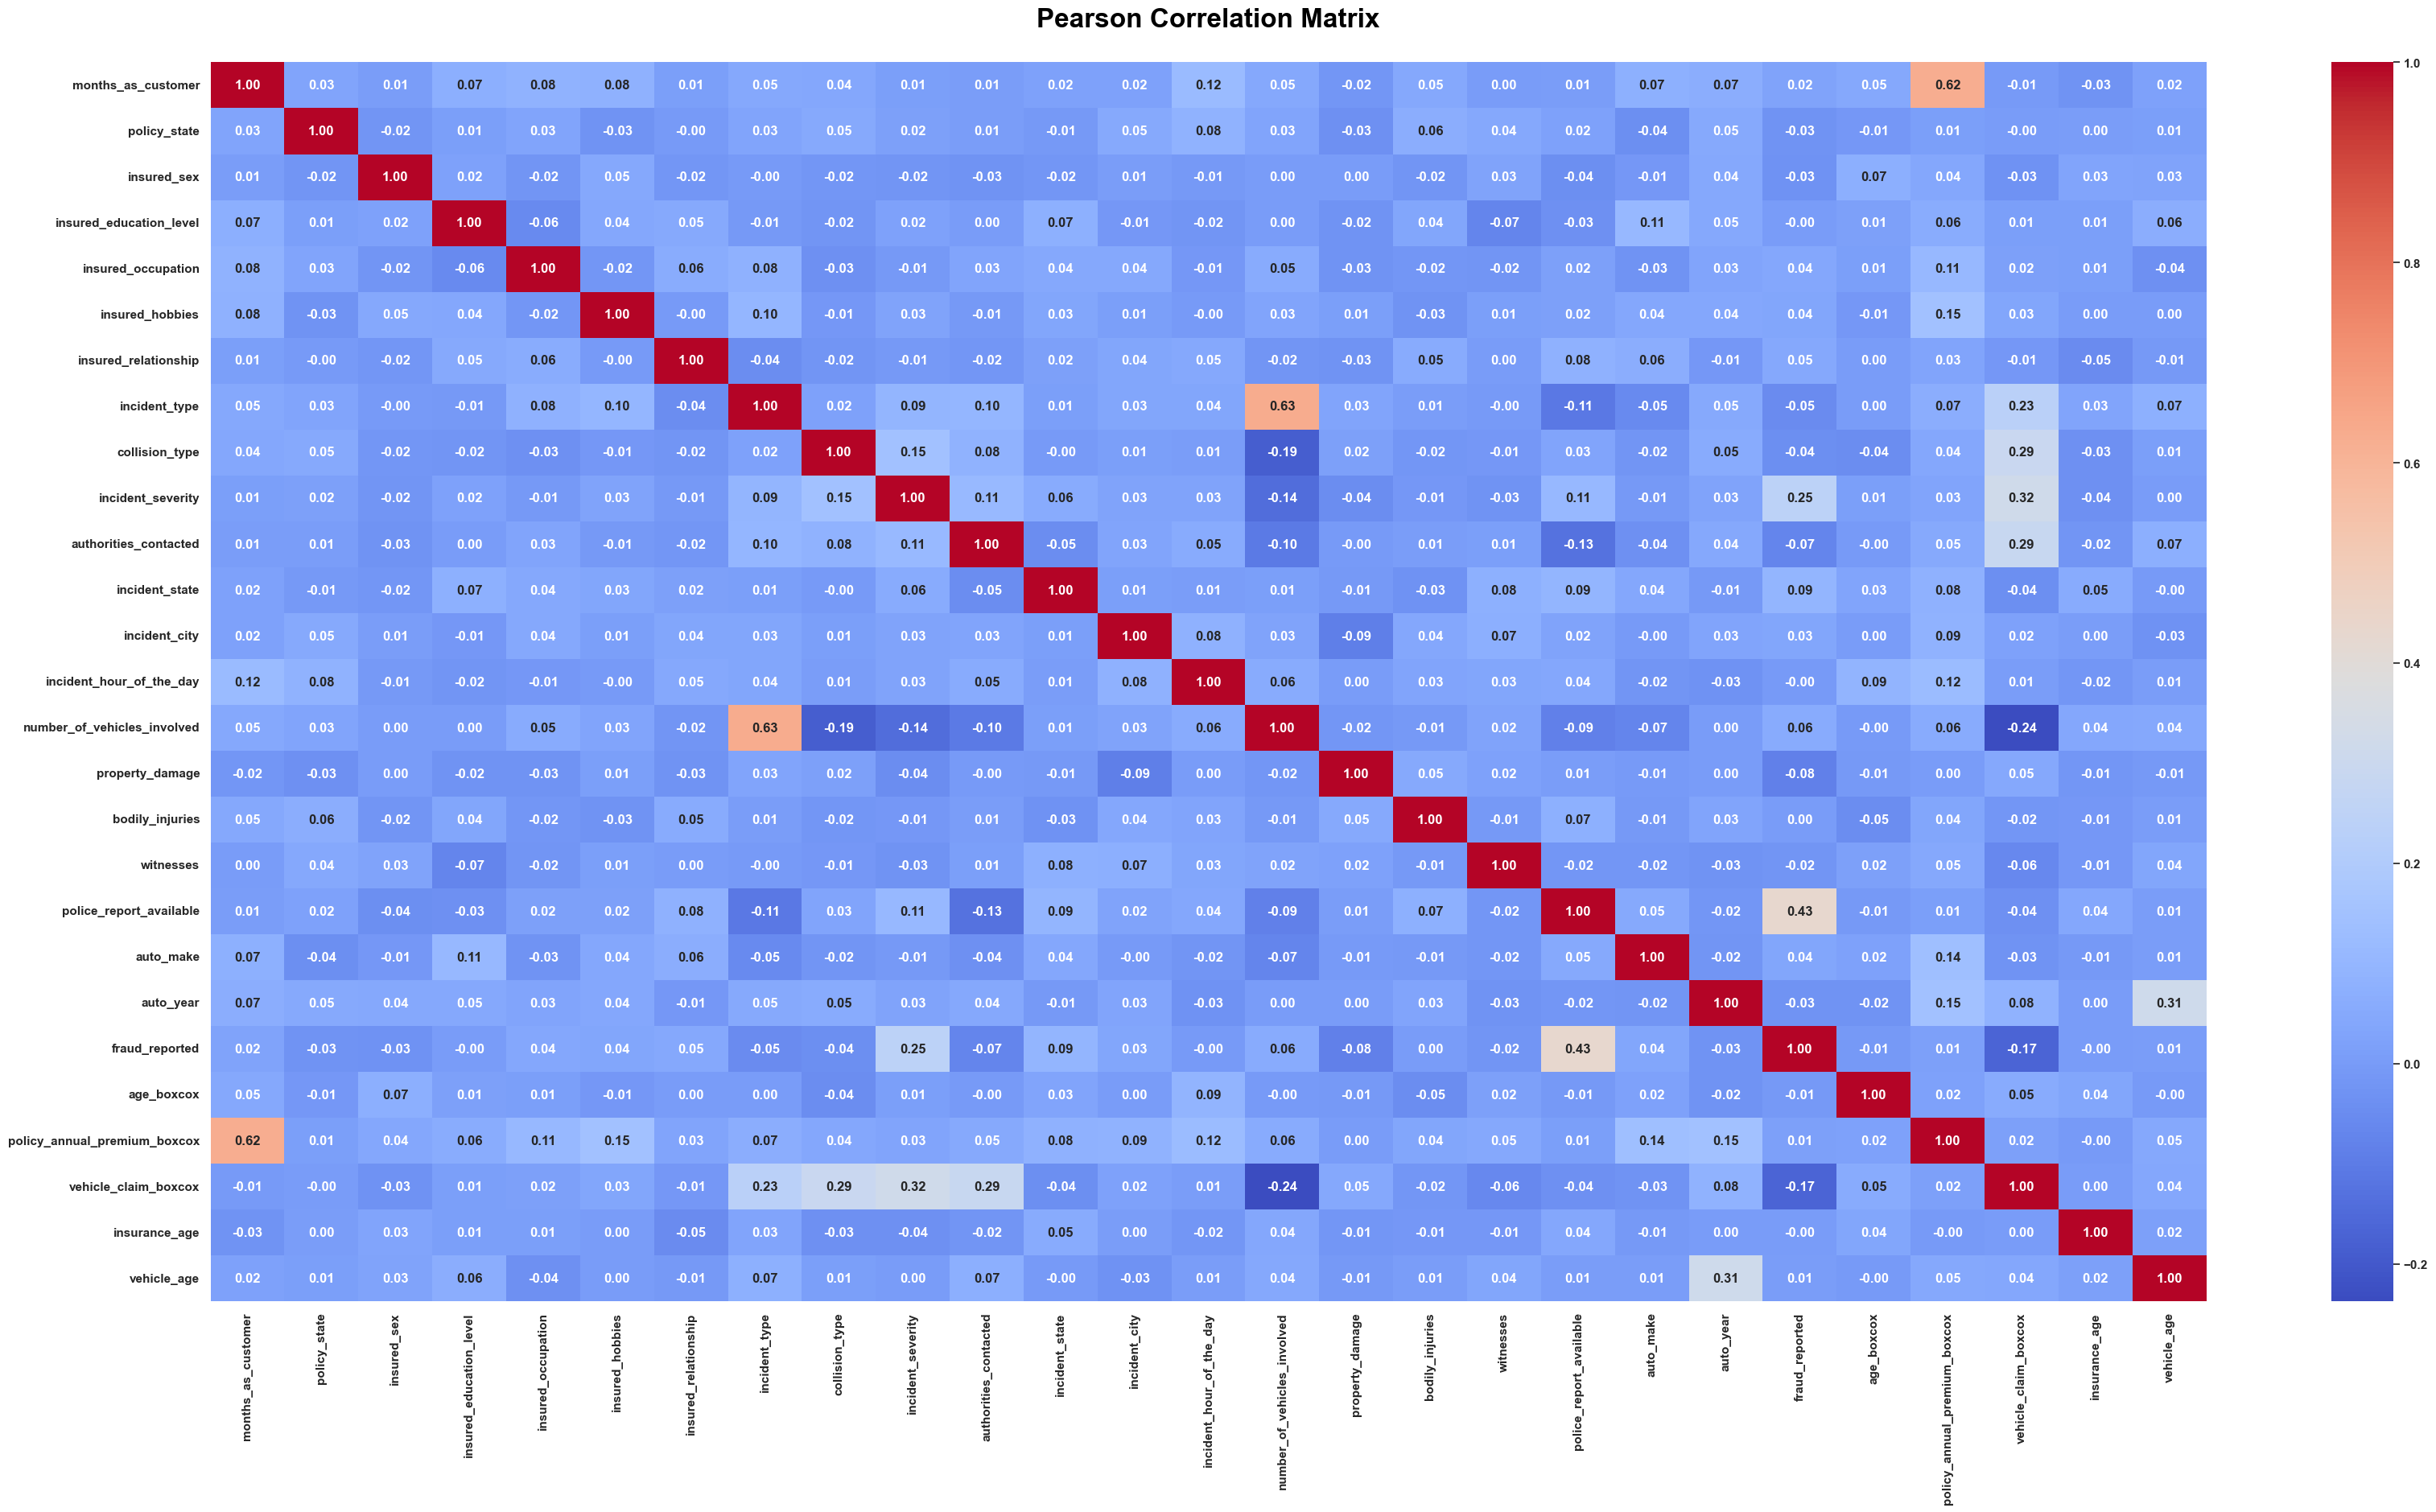

In [40]:
plt.figure(figsize=(40,20))
correlation_matrix = cor_col.corr(method='pearson')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Pearson Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


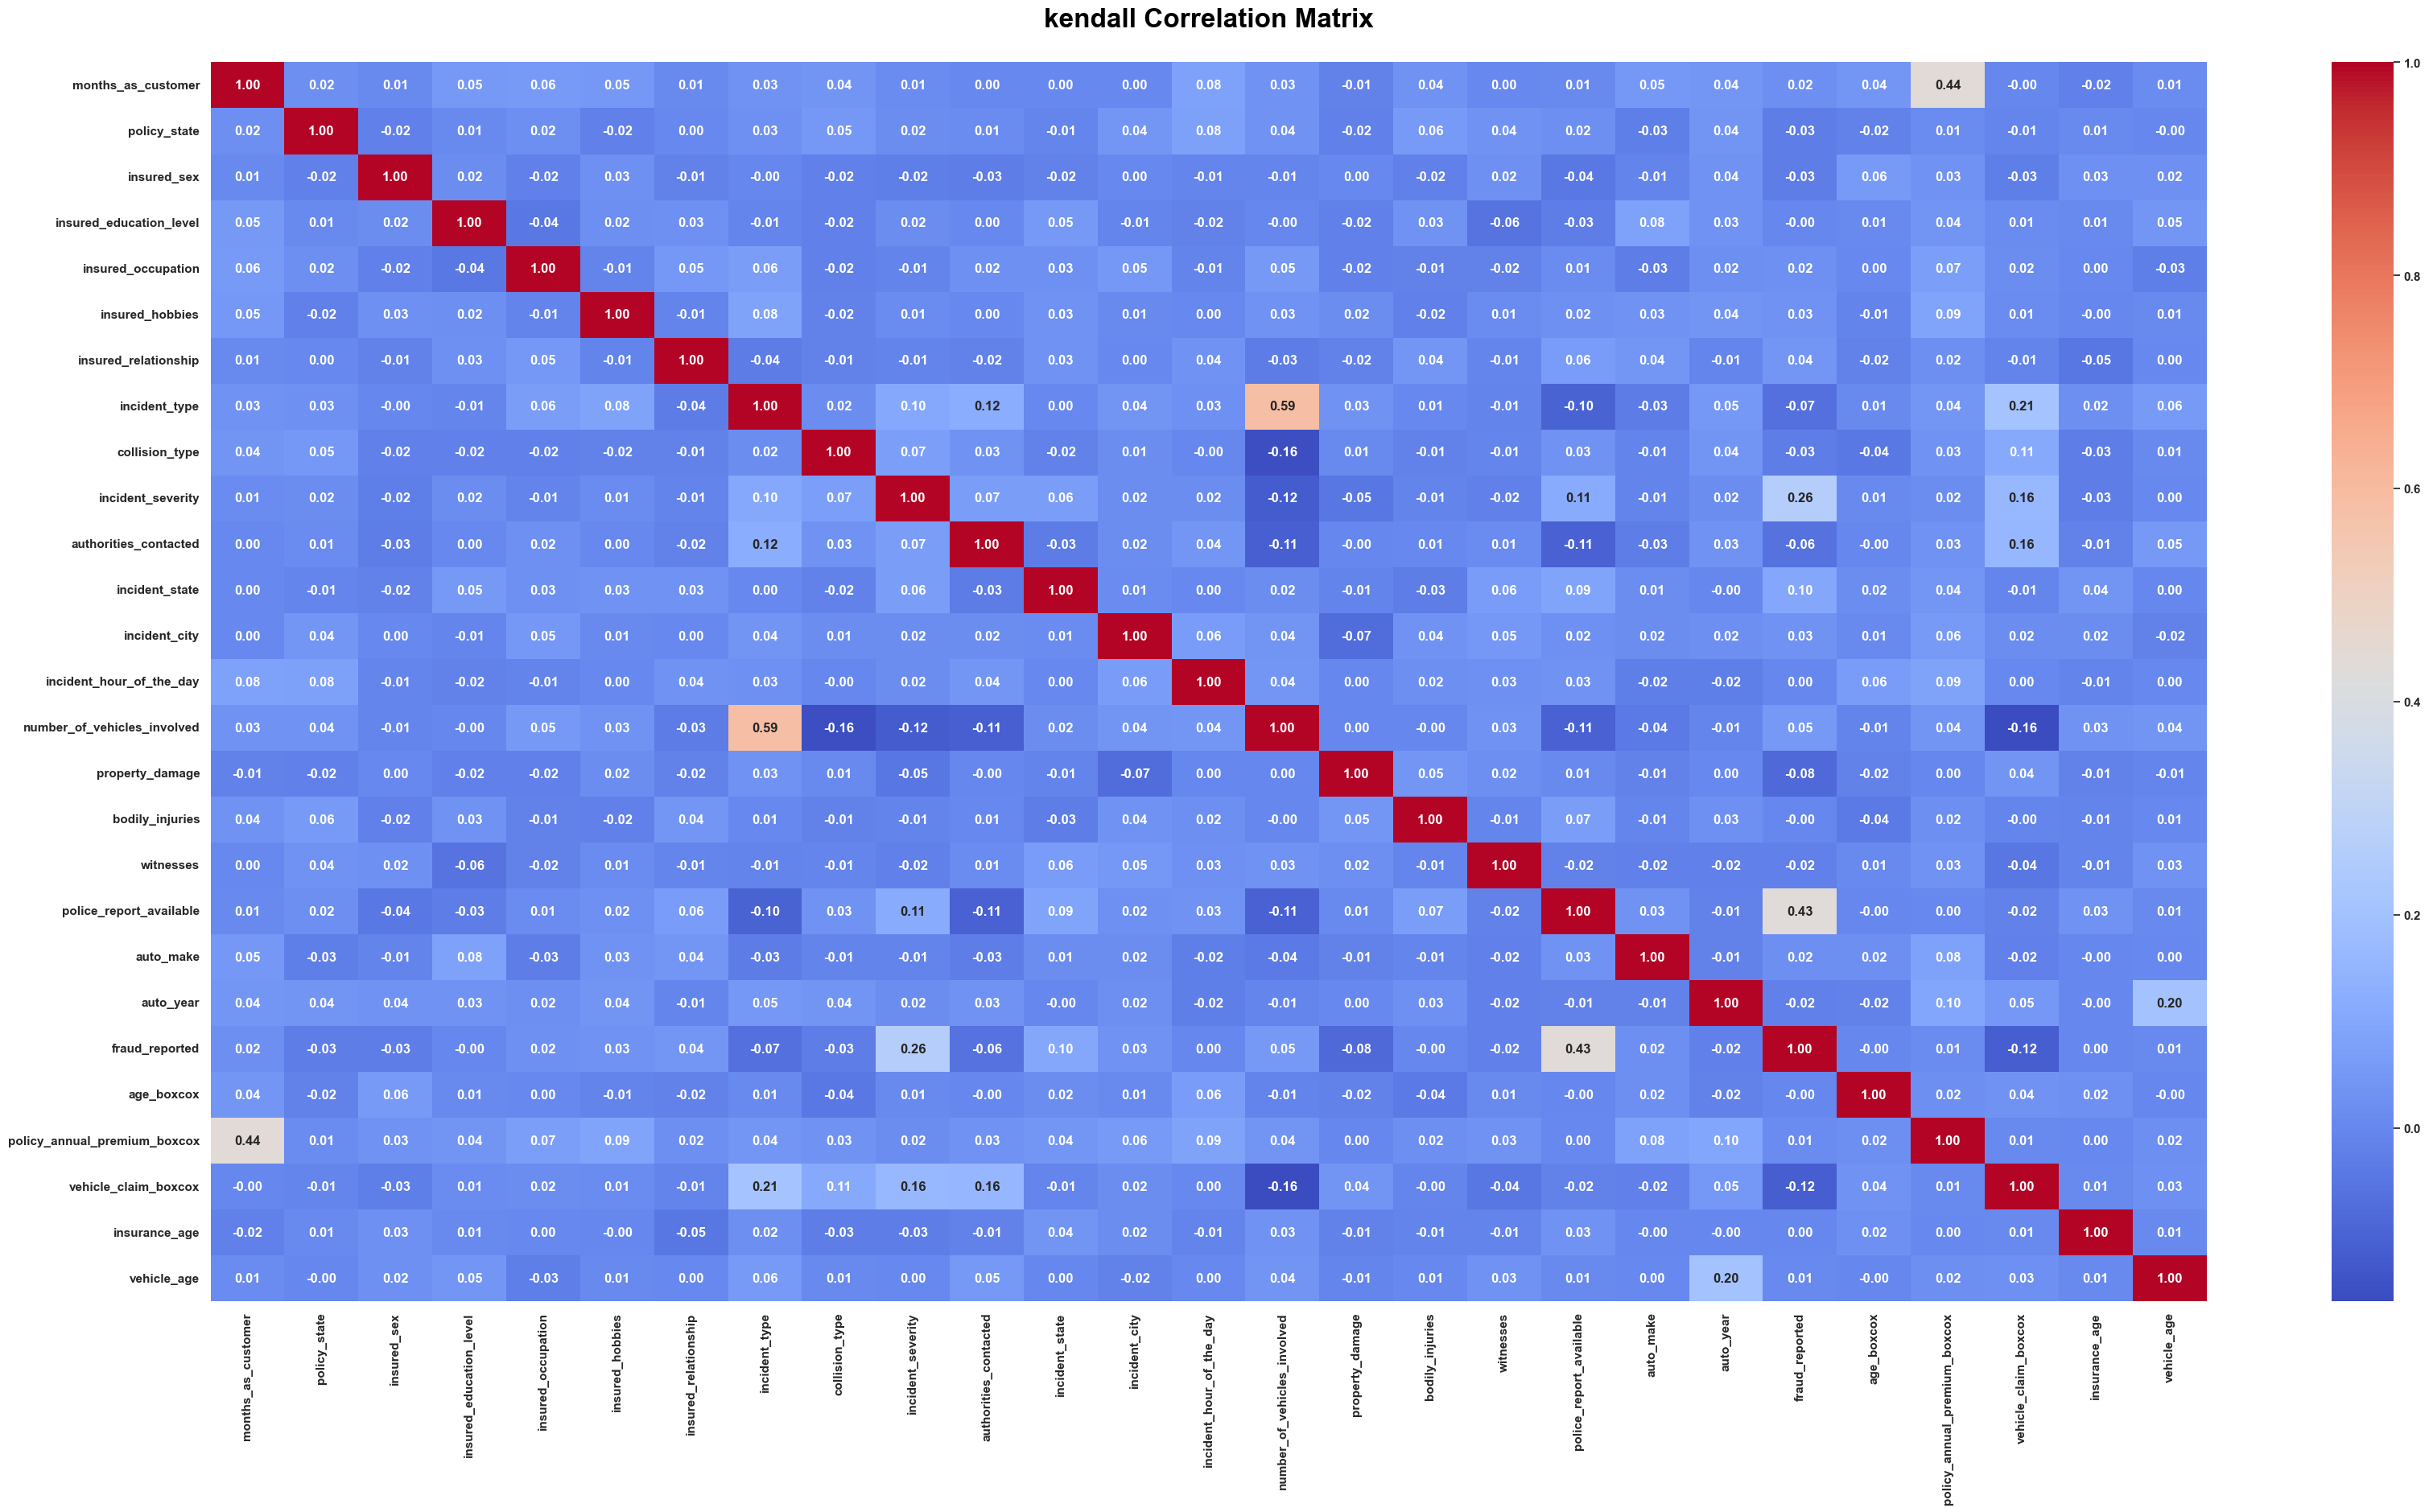

In [41]:
plt.figure(figsize=(40,20))
correlation_matrix = cor_col.corr(method='kendall')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('kendall Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [42]:
fea1 =['months_as_customer', 'policy_state', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'auto_make', 'auto_year',
        'age_boxcox', 'policy_annual_premium_boxcox',
        'insurance_age', 'vehicle_age']

fea2 = ['incident_severity', 'collision_type','policy_annual_premium_boxcox', 'months_as_customer','age_boxcox',
        'insurance_age','auto_make','insured_hobbies','insured_occupation','vehicle_claim_boxcox',]
Continuous = ['age_boxcox', 'policy_annual_premium_boxcox', 'insurance_age', 'vehicle_age', 'auto_year']
Nominal  =['policy_state', 'insured_sex', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 
                  'incident_type', 'collision_type', 'authorities_contacted', 'incident_state', 'incident_city', 
                  'property_damage', 'police_report_available', 'auto_make', 'fraud_reported']

In [43]:
Linear_regressor = LinearRegression()
evaluate_model(Linear_regressor, x_train[fea2], y_train, x_test[fea2], y_test)


LinearRegression

Training Time: 0.02 seconds

Coefficients -  [-3.40304281e+02  3.51084324e+01 -1.75216178e+00 -2.07514283e+00
  1.93098032e+03 -2.30852780e+01  2.01264613e+01  2.94925306e+01
 -1.43869654e+01  1.21841983e+00]
Test Mean Squared Error  -- 120483345.3693
Train Mean Squared Error  -- 120516169.7397

Test R2 Score  -- 0.9637
Train R2 Score  -- 0.9625

Test Mean Absolute Error  -- 7942.2667
Train Mean Absolute Error  -- 8087.1500

Test Median Absolute Error  -- 5138.3492
Train Median Absolute Error  -- 5515.9972

Test Explained Variance Score  -- 0.9637
Train Explained Variance Score  -- 0.9625

Test Max Error  -- 34341.0092
Train Max Error  -- 36998.5047

Test Root Mean Squared Error  -- 10976.4906
Train Root Mean Squared Error  -- 10977.9857

--------------------------------------------------


In [44]:
Ridge_regressor = Ridge(random_state=42)
evaluate_model(Ridge_regressor, x_train[fea2], y_train, x_test[fea2], y_test)


Ridge

Training Time: 0.01 seconds

Test Mean Squared Error  -- 120482617.5924
Train Mean Squared Error  -- 120516249.7265

Test R2 Score  -- 0.9637
Train R2 Score  -- 0.9625

Test Mean Absolute Error  -- 7942.8281
Train Mean Absolute Error  -- 8087.5136

Test Median Absolute Error  -- 5142.3290
Train Median Absolute Error  -- 5514.7086

Test Explained Variance Score  -- 0.9637
Train Explained Variance Score  -- 0.9625

Test Max Error  -- 34343.1077
Train Max Error  -- 36995.1716

Test Root Mean Squared Error  -- 10976.4574
Train Root Mean Squared Error  -- 10977.9893

--------------------------------------------------


In [45]:
Lasso_regressor = Lasso(random_state=42)
evaluate_model(Lasso_regressor, x_train[fea2], y_train, x_test[fea2], y_test)


Lasso

Training Time: 0.01 seconds

Test Mean Squared Error  -- 120479996.5927
Train Mean Squared Error  -- 120516181.9114

Test R2 Score  -- 0.9637
Train R2 Score  -- 0.9625

Test Mean Absolute Error  -- 7942.2638
Train Mean Absolute Error  -- 8087.2821

Test Median Absolute Error  -- 5140.1322
Train Median Absolute Error  -- 5516.1815

Test Explained Variance Score  -- 0.9637
Train Explained Variance Score  -- 0.9625

Test Max Error  -- 34340.7856
Train Max Error  -- 36995.7828

Test Root Mean Squared Error  -- 10976.3380
Train Root Mean Squared Error  -- 10977.9862

--------------------------------------------------


In [46]:
DT_Regressor = DecisionTreeRegressor(random_state=42)
evaluate_model(DT_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)


DecisionTreeRegressor

Training Time: 0.01 seconds

Test Mean Squared Error  -- 201641854.1384
Train Mean Squared Error  -- 0.0000

Test R2 Score  -- 0.9392
Train R2 Score  -- 1.0000

Test Mean Absolute Error  -- 10198.6768
Train Mean Absolute Error  -- 0.0000

Test Median Absolute Error  -- 7500.0064
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- 0.9393
Train Explained Variance Score  -- 1.0000

Test Max Error  -- 48000.7477
Train Max Error  -- 0.0000

Test Root Mean Squared Error  -- 14200.0653
Train Root Mean Squared Error  -- 0.0000

--------------------------------------------------


                        Feature  Importance
9          vehicle_claim_boxcox      0.9711
4                    age_boxcox      0.0066
7               insured_hobbies      0.0042
8            insured_occupation      0.0038
5                 insurance_age      0.0034
3            months_as_customer      0.0030
6                     auto_make      0.0029
2  policy_annual_premium_boxcox      0.0024
0             incident_severity      0.0019
1                collision_type      0.0007


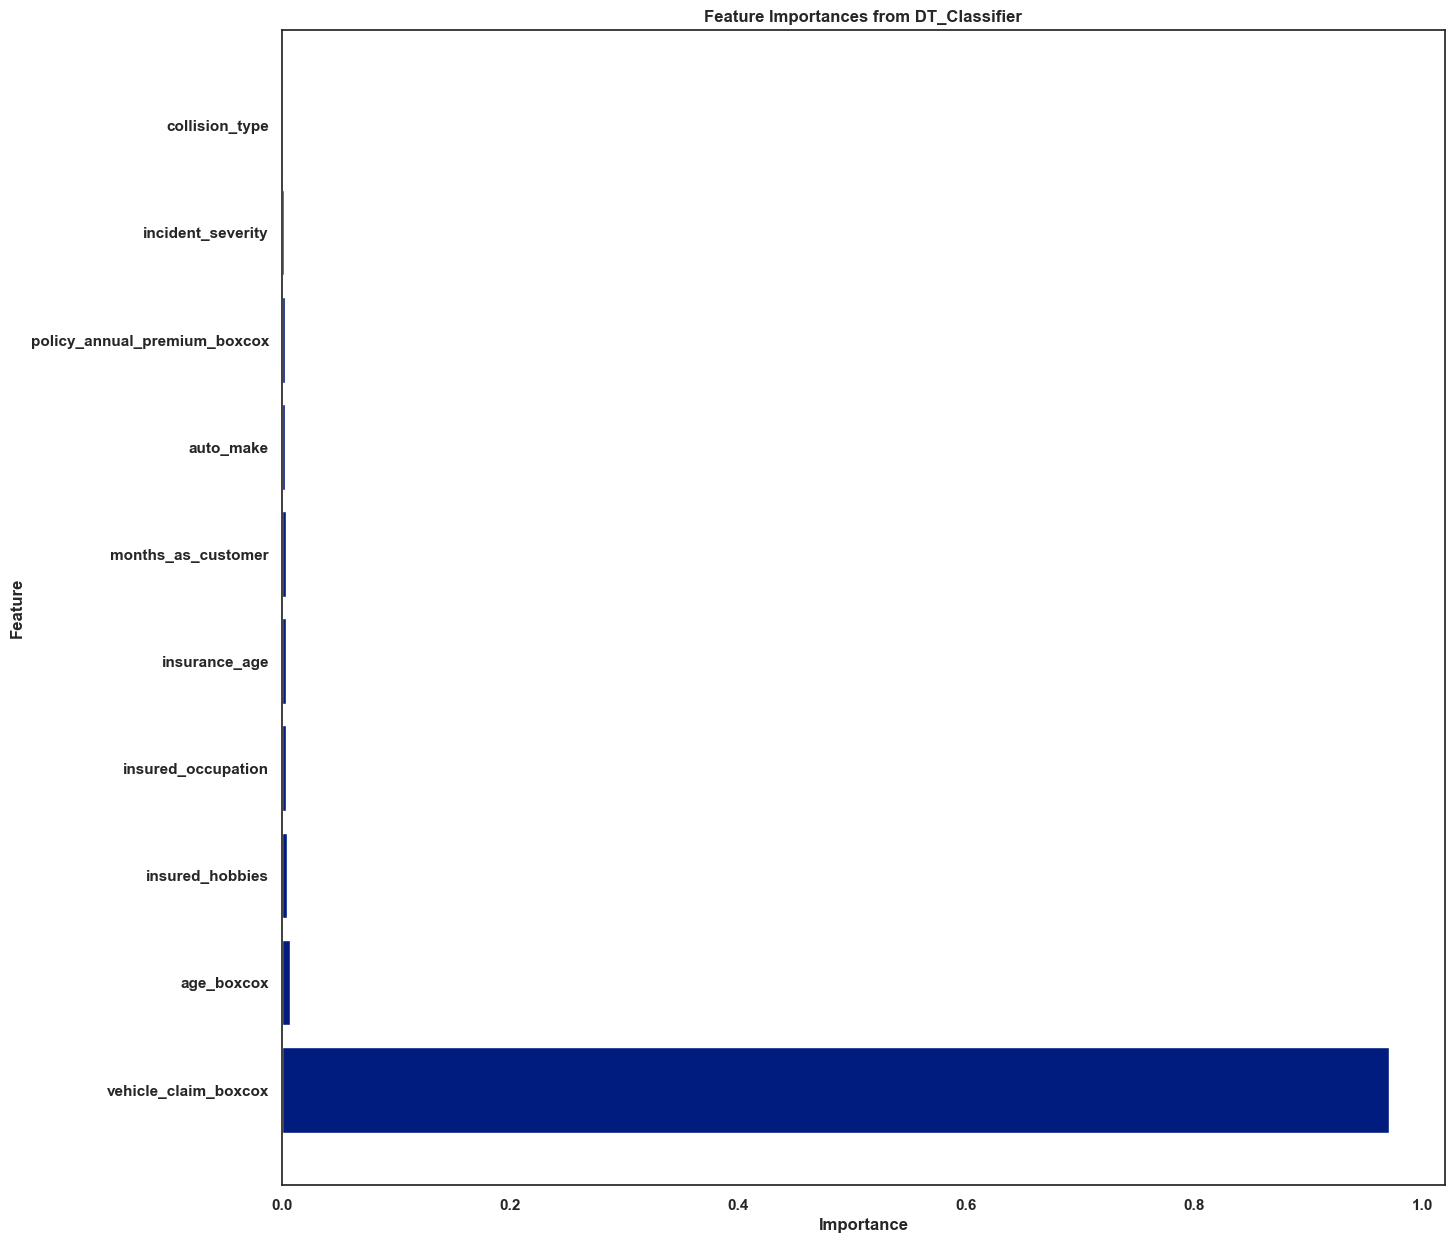

In [47]:
feature_importances = DT_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train[fea2].columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [48]:
RF_Regressor = RandomForestRegressor(n_estimators=10,random_state=42)
evaluate_model(RF_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)


RandomForestRegressor

Training Time: 0.06 seconds

Test Mean Squared Error  -- 145614799.1539
Train Mean Squared Error  -- 25926257.7562

Test R2 Score  -- 0.9561
Train R2 Score  -- 0.9919

Test Mean Absolute Error  -- 8657.7614
Train Mean Absolute Error  -- 3547.5395

Test Median Absolute Error  -- 6194.6473
Train Median Absolute Error  -- 2555.8622

Test Explained Variance Score  -- 0.9562
Train Explained Variance Score  -- 0.9919

Test Max Error  -- 39415.5215
Train Max Error  -- 24217.3097

Test Root Mean Squared Error  -- 12067.0957
Train Root Mean Squared Error  -- 5091.7834

--------------------------------------------------


                        Feature  Importance
9          vehicle_claim_boxcox      0.9688
7               insured_hobbies      0.0051
4                    age_boxcox      0.0048
3            months_as_customer      0.0043
5                 insurance_age      0.0041
2  policy_annual_premium_boxcox      0.0035
6                     auto_make      0.0034
8            insured_occupation      0.0032
1                collision_type      0.0014
0             incident_severity      0.0014


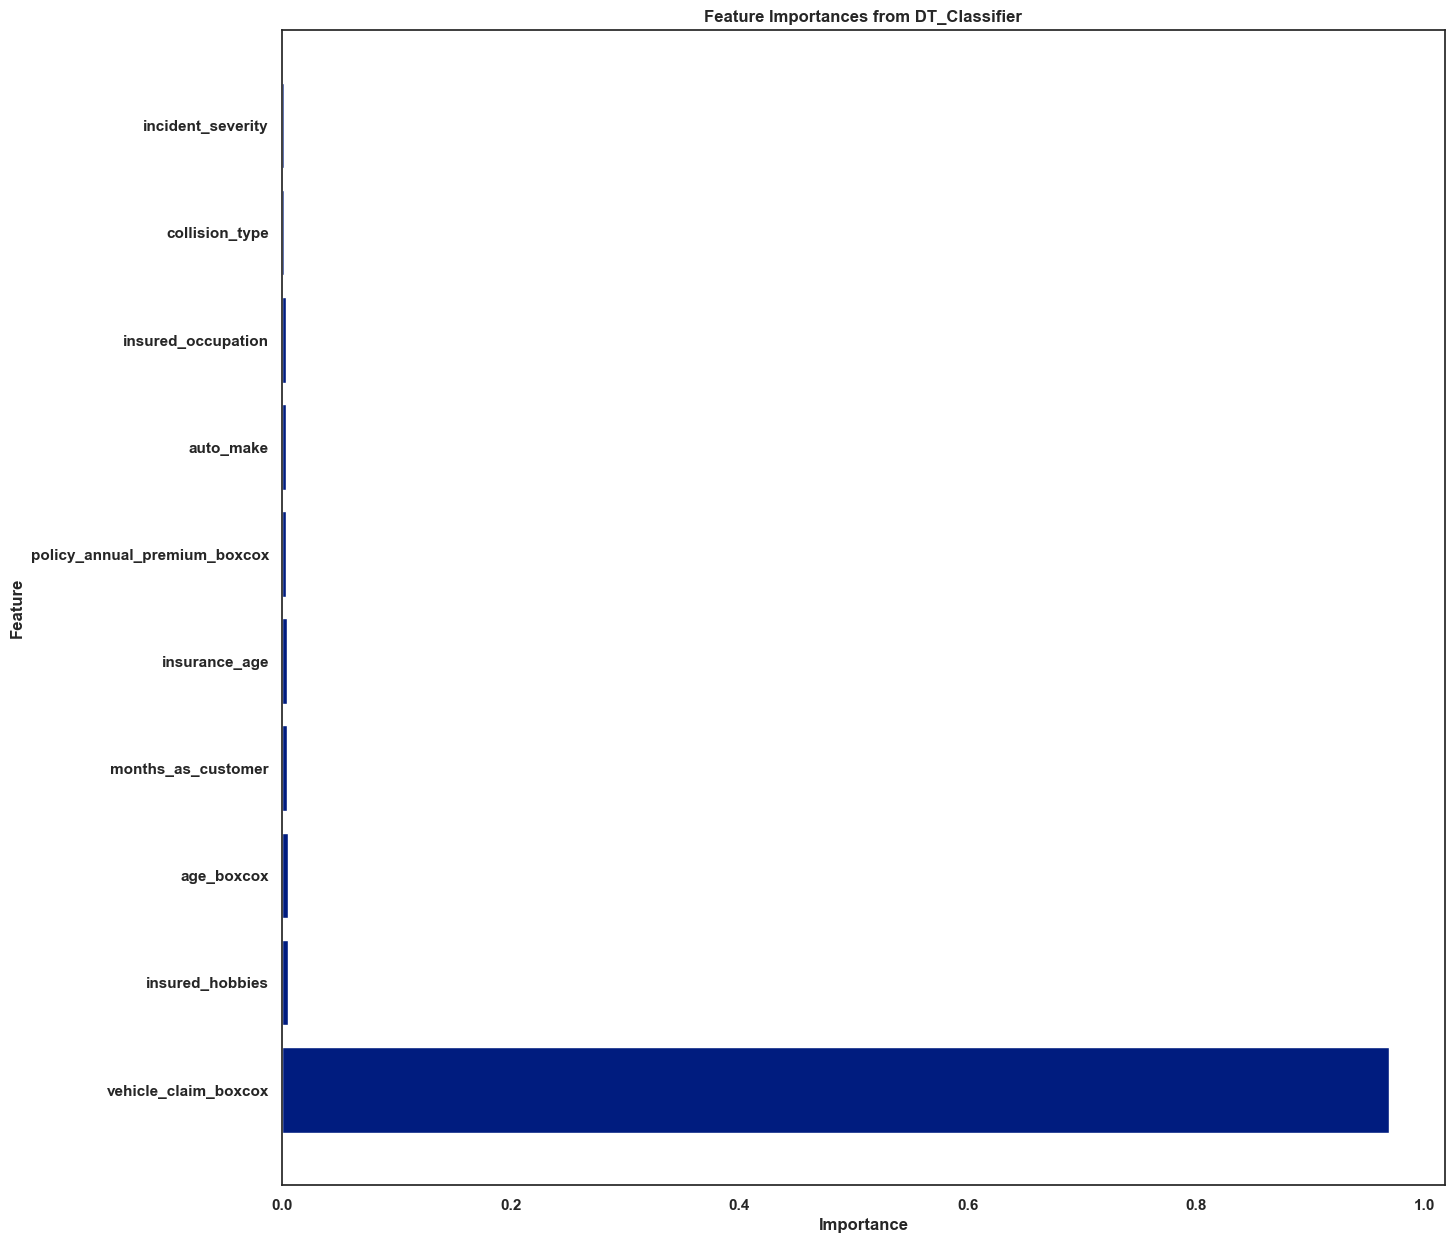

In [50]:
feature_importances = RF_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train[fea2].columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [51]:
ADA_Regressor = AdaBoostRegressor(random_state=42)
evaluate_model(ADA_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)


AdaBoostRegressor

Training Time: 0.35 seconds

Test Mean Squared Error  -- 141183511.2981
Train Mean Squared Error  -- 112272324.9354

Test R2 Score  -- 0.9574
Train R2 Score  -- 0.9651

Test Mean Absolute Error  -- 8708.0479
Train Mean Absolute Error  -- 8321.7168

Test Median Absolute Error  -- 5551.2832
Train Median Absolute Error  -- 6552.0277

Test Explained Variance Score  -- 0.9584
Train Explained Variance Score  -- 0.9657

Test Max Error  -- 35585.4562
Train Max Error  -- 26561.3735

Test Root Mean Squared Error  -- 11882.0668
Train Root Mean Squared Error  -- 10595.8636

--------------------------------------------------


                        Feature  Importance
9          vehicle_claim_boxcox      0.8993
5                 insurance_age      0.0266
6                     auto_make      0.0192
2  policy_annual_premium_boxcox      0.0191
8            insured_occupation      0.0153
3            months_as_customer      0.0132
4                    age_boxcox      0.0028
7               insured_hobbies      0.0023
0             incident_severity      0.0019
1                collision_type      0.0002


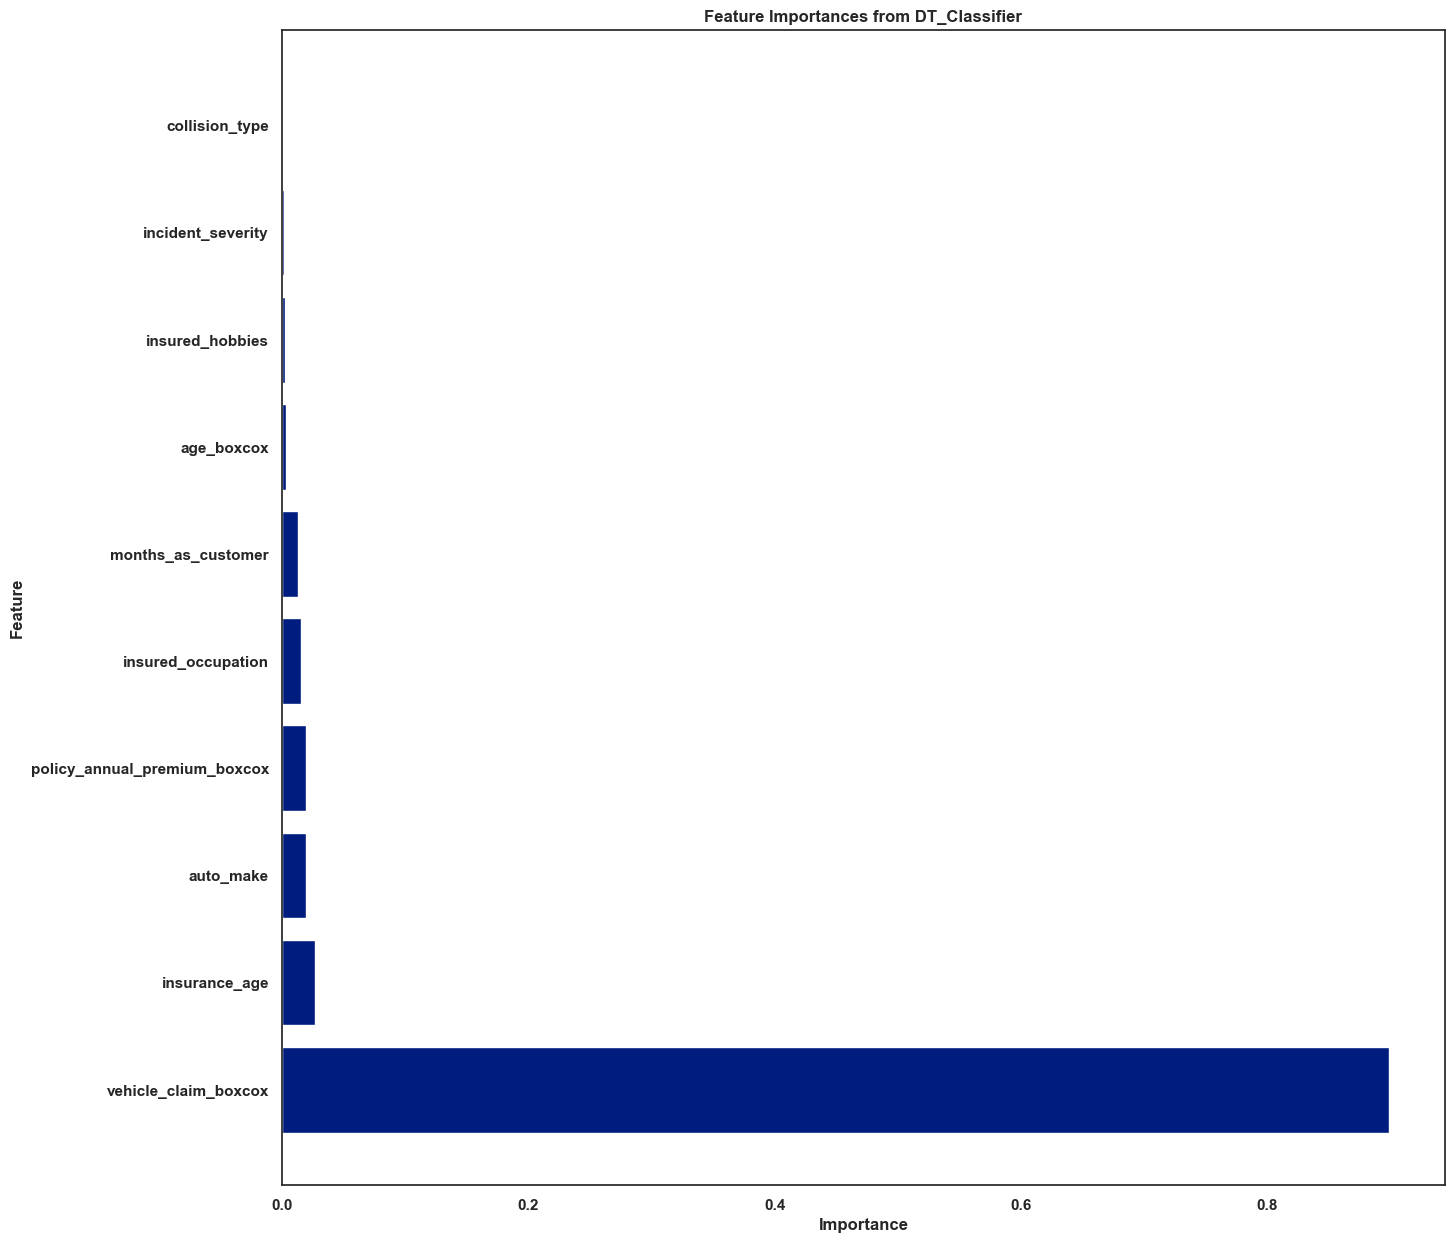

In [53]:
feature_importances = ADA_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train[fea2].columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [54]:
fea_imp = ['witnesses','insured_sex','police_report_available','collision_type','incident_type','months_as_customer','incident_severity','property_damage',]


GB_Regressor = GradientBoostingRegressor(random_state=42)
evaluate_model(GB_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)


GradientBoostingRegressor

Training Time: 0.52 seconds

Test Mean Squared Error  -- 124603332.7132
Train Mean Squared Error  -- 64886741.0471

Test R2 Score  -- 0.9624
Train R2 Score  -- 0.9798

Test Mean Absolute Error  -- 7762.4616
Train Mean Absolute Error  -- 5864.7873

Test Median Absolute Error  -- 4075.7340
Train Median Absolute Error  -- 4250.0789

Test Explained Variance Score  -- 0.9624
Train Explained Variance Score  -- 0.9798

Test Max Error  -- 38430.9000
Train Max Error  -- 34938.7695

Test Root Mean Squared Error  -- 11162.5863
Train Root Mean Squared Error  -- 8055.2307

--------------------------------------------------


                        Feature  Importance
9          vehicle_claim_boxcox      0.9883
7               insured_hobbies      0.0030
2  policy_annual_premium_boxcox      0.0017
5                 insurance_age      0.0015
3            months_as_customer      0.0014
4                    age_boxcox      0.0014
6                     auto_make      0.0010
8            insured_occupation      0.0009
1                collision_type      0.0005
0             incident_severity      0.0002


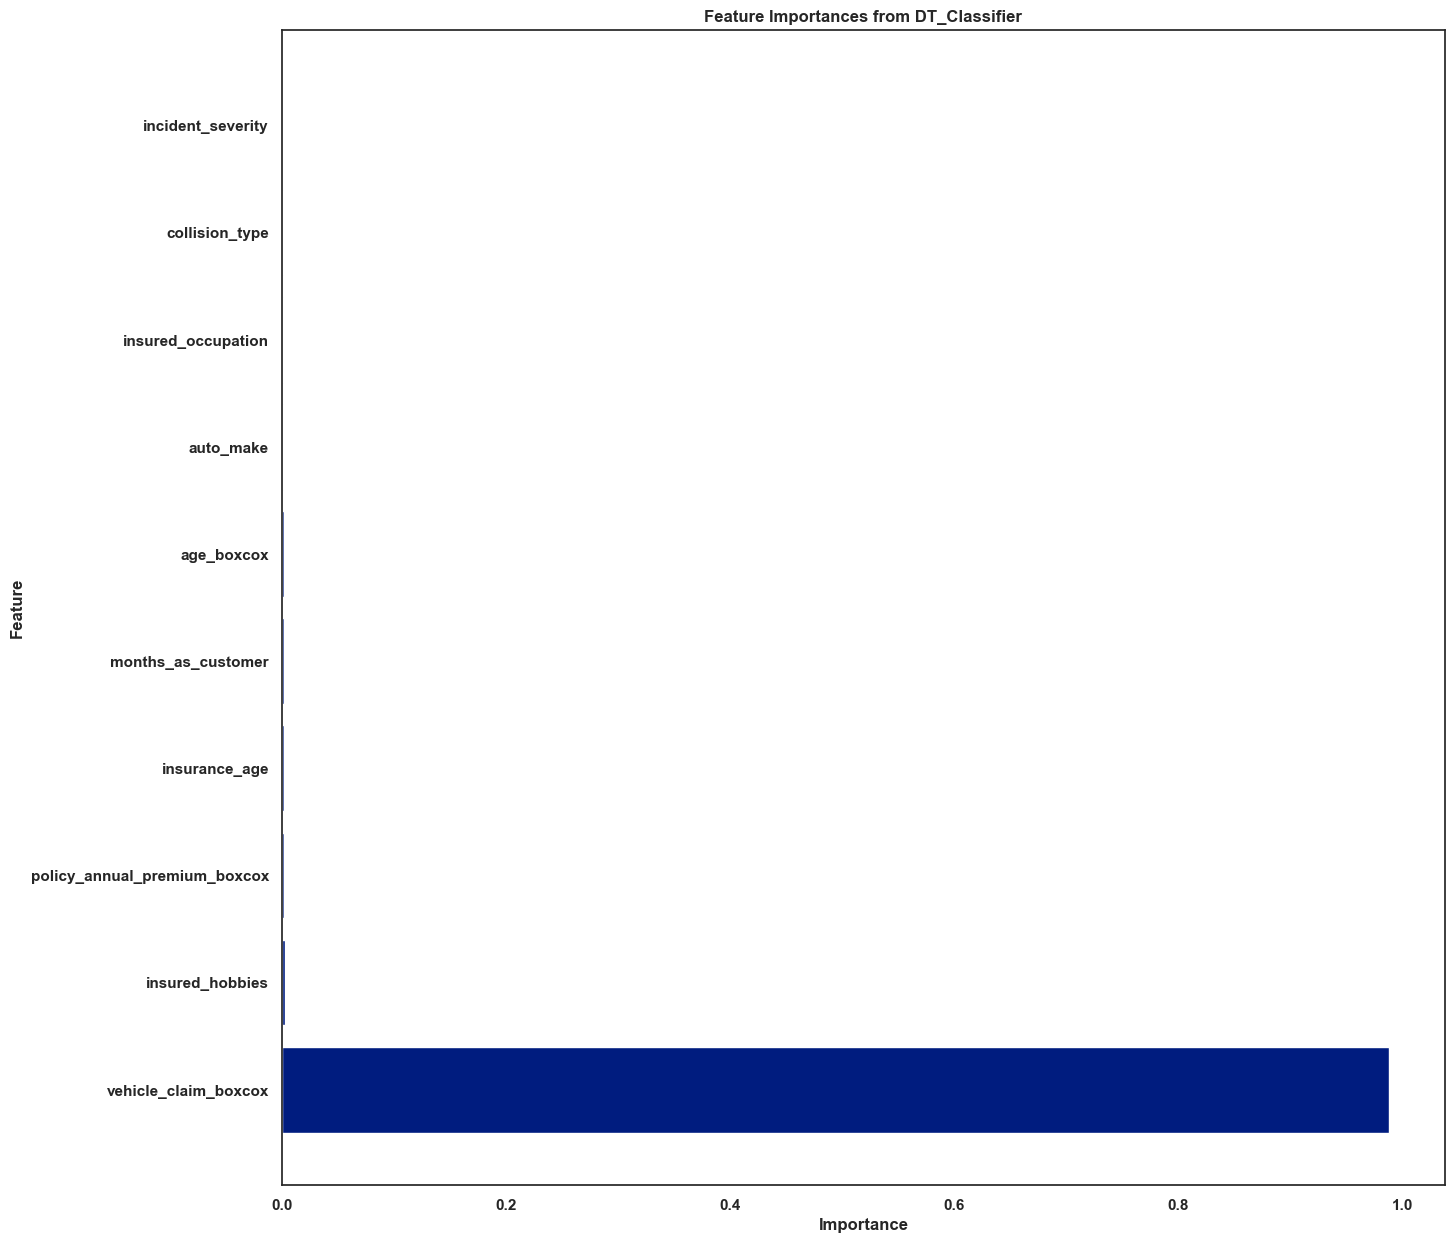

In [57]:
feature_importances = GB_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train[fea2].columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [58]:
# xg_x_train = x_train_scaled_df[feature_columns].values
# xg_x_test = x_test_scaled_df[feature_columns].values

XGB_Regressor = xg.XGBRegressor(random_state=42)
evaluate_model(XGB_Regressor, x_train[fea2].values, y_train, x_test[fea2].values, y_test)


XGBRegressor

Training Time: 1.94 seconds

Test Mean Squared Error  -- 145506323.5775
Train Mean Squared Error  -- 39346.8545

Test R2 Score  -- 0.9561
Train R2 Score  -- 1.0000

Test Mean Absolute Error  -- 8694.6562
Train Mean Absolute Error  -- 126.6676

Test Median Absolute Error  -- 6317.2951
Train Median Absolute Error  -- 70.1647

Test Explained Variance Score  -- 0.9561
Train Explained Variance Score  -- 1.0000

Test Max Error  -- 45960.8216
Train Max Error  -- 978.8866

Test Root Mean Squared Error  -- 12062.6002
Train Root Mean Squared Error  -- 198.3604

--------------------------------------------------


In [59]:
ET_Regressor = ExtraTreesRegressor(random_state=42)
evaluate_model(ET_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)



ExtraTreesRegressor

Training Time: 0.52 seconds

Test Mean Squared Error  -- 134299373.9168
Train Mean Squared Error  -- 0.0000

Test R2 Score  -- 0.9595
Train R2 Score  -- 1.0000

Test Mean Absolute Error  -- 8293.5508
Train Mean Absolute Error  -- 0.0000

Test Median Absolute Error  -- 6204.9409
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- 0.9596
Train Explained Variance Score  -- 1.0000

Test Max Error  -- 42901.6149
Train Max Error  -- 0.0000

Test Root Mean Squared Error  -- 11588.7607
Train Root Mean Squared Error  -- 0.0000

--------------------------------------------------


In [54]:
params = {'n_neighbors' : list(range(1,22))}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=3, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train[fea2],y_train)

print(KNN_grid_model.best_params_)


Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3] END ............n_neighbors=1;, score=-268703043.816 total time=   0.0s
[CV 2/3] END ............n_neighbors=1;, score=-305647026.112 total time=   0.0s
[CV 3/3] END ............n_neighbors=1;, score=-250618750.976 total time=   0.0s
[CV 1/3] END ............n_neighbors=2;, score=-204216324.831 total time=   0.0s
[CV 2/3] END ............n_neighbors=2;, score=-241612510.567 total time=   0.0s
[CV 3/3] END ............n_neighbors=2;, score=-196552577.353 total time=   0.0s
[CV 1/3] END ............n_neighbors=3;, score=-176496382.195 total time=   0.0s
[CV 2/3] END ............n_neighbors=3;, score=-210465996.796 total time=   0.0s
[CV 3/3] END ............n_neighbors=3;, score=-177072229.054 total time=   0.0s
[CV 1/3] END ............n_neighbors=4;, score=-151591296.927 total time=   0.0s
[CV 2/3] END ............n_neighbors=4;, score=-188175863.359 total time=   0.0s
[CV 3/3] END ............n_neighbors=4;, score=-

In [55]:
print(f"KNN Best Score - {KNN_grid_model.best_score_}\n\nKNN Best Params - {KNN_grid_model.best_params_}\n\nKNN Best Estimater - {KNN_grid_model.best_estimator_} \n\nKNN Best Index - {KNN_grid_model.best_index_} ")

KNN Best Score - -135710294.32801738

KNN Best Params - {'n_neighbors': 16}

KNN Best Estimater - KNeighborsRegressor(n_neighbors=16) 

KNN Best Index - 15 


In [56]:
KNN_Regressor = KNeighborsRegressor(n_neighbors=16)
evaluate_model(KNN_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)



KNeighborsRegressor

Training Time: 0.01 seconds

Test Mean Squared Error  -- 123525769.0713
Train Mean Squared Error  -- 115503946.7127

Test R2 Score  -- 0.9627
Train R2 Score  -- 0.9641

Test Mean Absolute Error  -- 7840.8051
Train Mean Absolute Error  -- 7712.8309

Test Median Absolute Error  -- 5389.5225
Train Median Absolute Error  -- 5579.0506

Test Explained Variance Score  -- 0.9629
Train Explained Variance Score  -- 0.9641

Test Max Error  -- 37809.8762
Train Max Error  -- 40433.2005

Test Root Mean Squared Error  -- 11114.2147
Train Root Mean Squared Error  -- 10747.2762

--------------------------------------------------


In [60]:
GB_Regressor = GradientBoostingRegressor(random_state=42)
evaluate_model(GB_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)


GradientBoostingRegressor

Training Time: 0.42 seconds

Test Mean Squared Error  -- 124603332.7132
Train Mean Squared Error  -- 64886741.0471

Test R2 Score  -- 0.9624
Train R2 Score  -- 0.9798

Test Mean Absolute Error  -- 7762.4616
Train Mean Absolute Error  -- 5864.7873

Test Median Absolute Error  -- 4075.7340
Train Median Absolute Error  -- 4250.0789

Test Explained Variance Score  -- 0.9624
Train Explained Variance Score  -- 0.9798

Test Max Error  -- 38430.9000
Train Max Error  -- 34938.7695

Test Root Mean Squared Error  -- 11162.5863
Train Root Mean Squared Error  -- 8055.2307

--------------------------------------------------


In [57]:
params = {'learning_rate' :np.arange(0.1, .3, 0.1),
          'n_estimators' : range(1,100,10)
        
}

GB_Regressor = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=params, cv=3, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')
GB_Regressor.fit(x_train[fea2],y_train)

print(GB_Regressor.best_params_,'\n',GB_Regressor.best_score_)




Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END learning_rate=0.1, n_estimators=1;, score=-2503414600.989 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=1;, score=-2705039514.939 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=1;, score=-2788981072.142 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=11;, score=-447323110.047 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=11;, score=-440238645.745 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=11;, score=-485055958.065 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=21;, score=-179442872.299 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=21;, score=-165543105.663 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=21;, score=-184867518.066 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=31;, score=-144579124.236 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estim

In [61]:
GB_Regressor = GradientBoostingRegressor(random_state=42,learning_rate=0.1,n_estimators=51)
evaluate_model(GB_Regressor, x_train[fea2], y_train, x_test[fea2], y_test)


GradientBoostingRegressor

Training Time: 0.18 seconds

Test Mean Squared Error  -- 121963350.9041
Train Mean Squared Error  -- 85924822.2601

Test R2 Score  -- 0.9632
Train R2 Score  -- 0.9733

Test Mean Absolute Error  -- 7684.4768
Train Mean Absolute Error  -- 6766.0962

Test Median Absolute Error  -- 3949.9361
Train Median Absolute Error  -- 4855.4316

Test Explained Variance Score  -- 0.9633
Train Explained Variance Score  -- 0.9733

Test Max Error  -- 35649.5859
Train Max Error  -- 37259.5792

Test Root Mean Squared Error  -- 11043.7019
Train Root Mean Squared Error  -- 9269.5643

--------------------------------------------------


In [62]:
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/GB_Regressor.pkl', 'wb') as f:
    pickle.dump(GB_Regressor,f)